In [ ]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import gzip

# For NLP processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import pos_tag
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# For topic modeling
from gensim import corpora, models

# For visualization of topics
from wordcloud import WordCloud

# For statistical analysis
from scipy.stats import (
    chi2_contingency, chi2, ttest_ind, mannwhitneyu,
    entropy, ks_2samp
)

# For embeddings and similarity calculations
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data loading
from analysis.beerdata_loader import BeerDataLoader

# To show progress
from tqdm import tqdm

#For multiprocessing
from multiprocessing import Pool

#For shapefiles
import geopandas as gpd

import os
import pickle

from gensim.models import LdaModel
from gensim.corpora import Dictionary

tqdm.pandas()

<h1 style="font-size: 40px;">Step 0: dataloader</h1>

Note that we created a data merger between Beeradvocate and Ratebeer available in src/data/dataset_merger.ipynb but we decided to first focus on Beeradvocate and later extend our analysis to Ratebeer

The following is then the datamerger for Beeradvocate only

In [4]:
from analysis.beerdata_loader import BeerDataLoader

data_loader = BeerDataLoader(data_dir="../ada-2024-project-data-crusadas/data/BeerAdvocate", force_process=False)

ba_reviews_df, ba_ratings_df, ba_beers_df, ba_breweries_df, ba_users_df = data_loader.load_all_data()

Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\ratings_processed.csv' already exists. Skipping processing.


<h1 style="font-size: 40px;">Step 1: The rise of the IPA: ratings side</h1>

In this first big step, we try to evaluate how popular is the IPA, excluded, for this step, the reviews. We evaluate IPA with the textual description contained in reviews for step 2. The goal of this step is to familiarize ourselfs with the data and try to extract big features of the IPA. Note that for some graphs, even if a trend to appear, we didn't check if this trend was statistically significant. We will focus on that later, for the following of the project.

<h1 style="font-size: 30px;">1.1: Location of beers</h1>

Note that we here decided to show only US states and country with at least 1000 ratings and how is the distribution of ratings

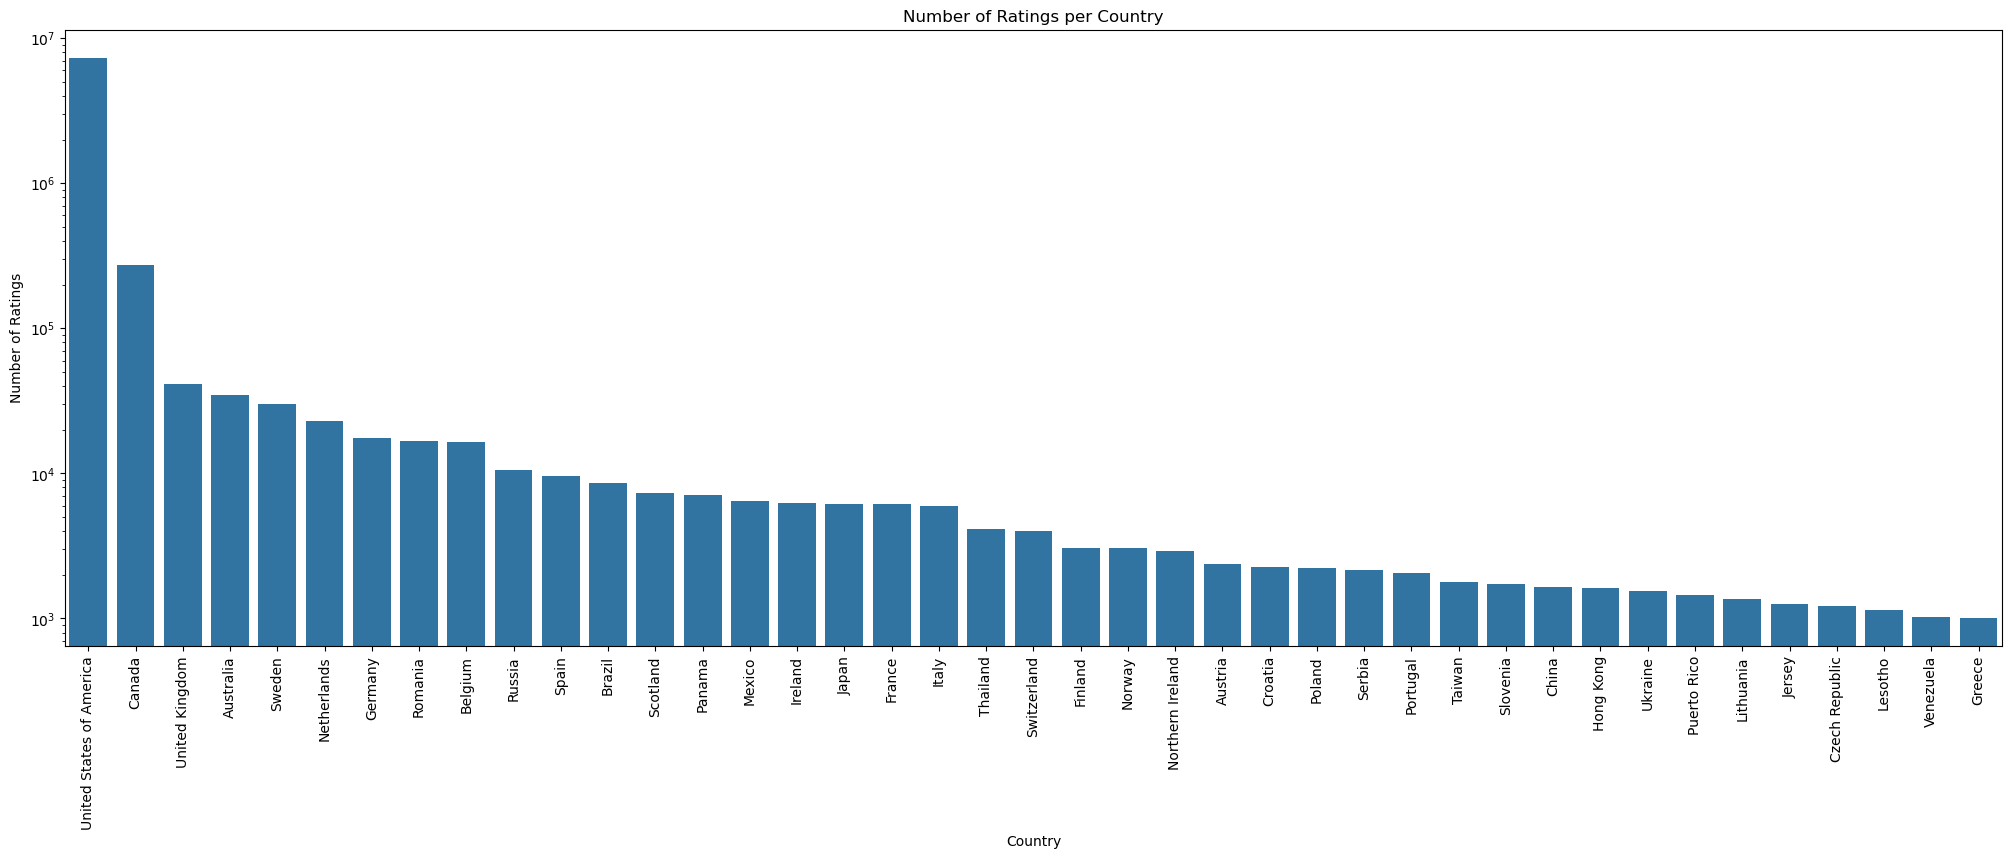

In [20]:
def clean_location(location):
    #The goal of this method is to change the name of some countries
    #to be able to use them on the shapefile
    if isinstance(location, str):  # Check if location is a string
        country = location.split(',')[0].strip()
        # Replace "United States" with "United States of America"
        if country == "United States":
            return "United States of America"
        if country == "England":
            return "United Kingdom"
        return country
    return None

# Apply the cleanup function
ba_users_df['cleaned_location'] = ba_users_df['location'].apply(clean_location)
#Compute the number of ratings per location
nbr_ratings_per_location = ba_users_df.groupby('cleaned_location')['nbr_ratings'].sum().reset_index()
#Keep only the location where there were more than 1000 ratings
nbr_ratings_per_location = nbr_ratings_per_location[nbr_ratings_per_location['nbr_ratings'] > 1000].sort_values(by='nbr_ratings', ascending=False)

plt.figure(figsize=(25, 8))
sns.barplot(data=nbr_ratings_per_location, x='cleaned_location', y='nbr_ratings', log=True)
plt.title('Number of Ratings per Country')
plt.xlabel('Country')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)  # Rotate location names vertically
plt.show()

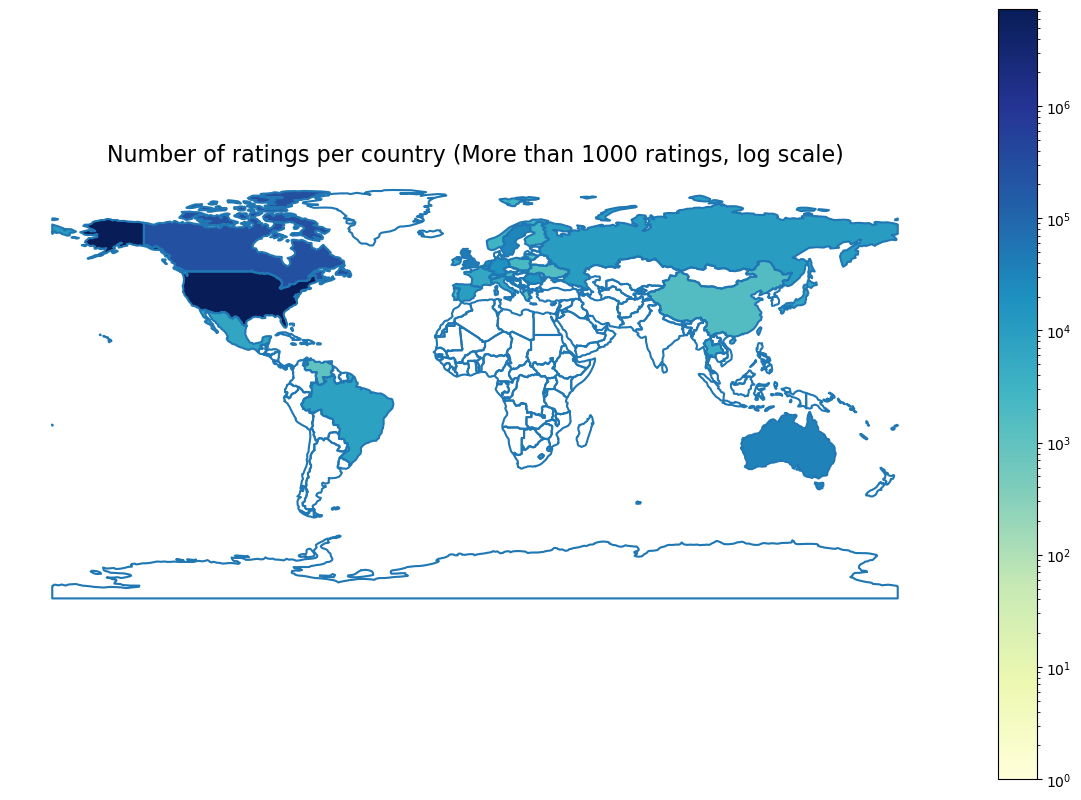

In [21]:
shapefile_path = r'.\src\data\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Merge your ratings data with the world GeoDataFrame
merged = world.merge(nbr_ratings_per_location, how='left', left_on='SOVEREIGNT', right_on='cleaned_location')

# Fill NaN values in 'nbr_ratings' with 0 for visualization
merged['nbr_ratings'] = merged['nbr_ratings'].fillna(0)

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax)  # Plot the world boundaries
merged.plot(column='nbr_ratings', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', 
            norm=LogNorm(vmin=1, vmax=merged['nbr_ratings'].max()), legend=True)

# Customizing the plot
ax.set_title('Number of ratings per country (More than 1000 ratings, log scale)', fontsize=16)
ax.set_axis_off()  # Turn off the axis
plt.show()

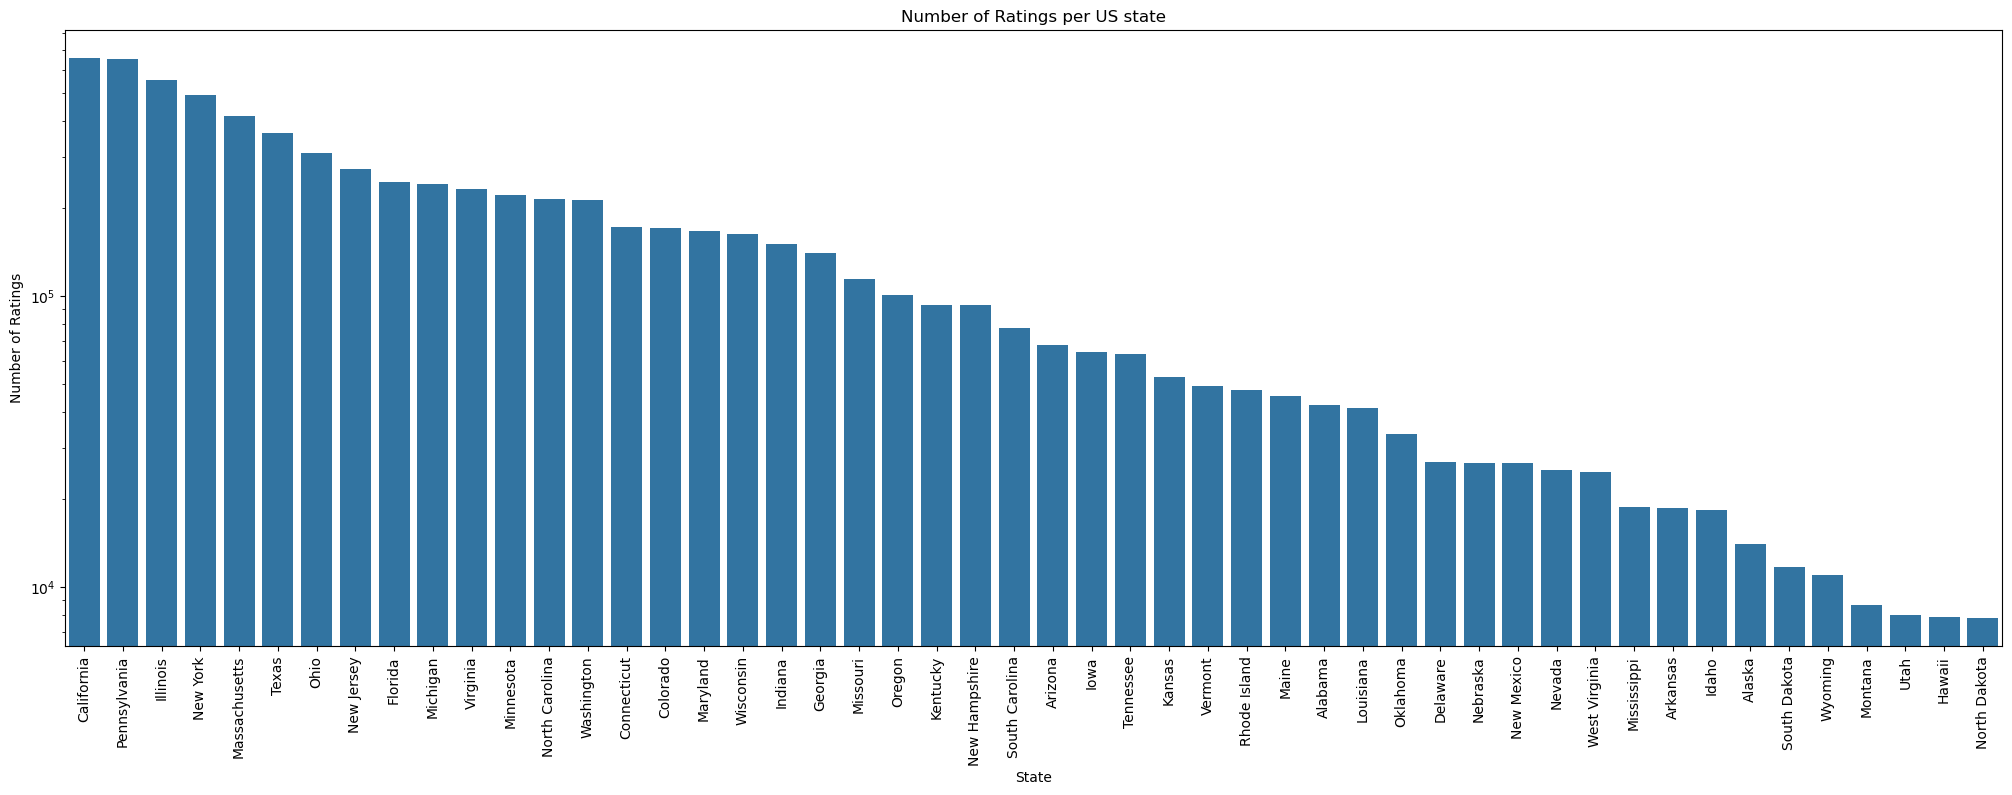

In [22]:
def clean_states(location):
    # This function will clean the location string by extracting the last part (state or city)
    if isinstance(location, str):  # Check if location is a string
        # Split the location by commas and strip whitespace
        parts = location.split(',')
        # Return the last part, which should be the state or city
        return parts[-1].strip() if parts else None
    return None

# Apply the cleanup function
us_states_df = ba_users_df[ba_users_df['location'].str.startswith("United States", na=False)].copy()
us_states_df['states'] = us_states_df['location'].apply(clean_states)
#Compute the number of ratings per location
nbr_ratings_per_location = us_states_df.groupby('states')['nbr_ratings'].sum().reset_index()
#Keep only the location where there were more than 1000 ratings
nbr_ratings_per_location = nbr_ratings_per_location[nbr_ratings_per_location['nbr_ratings'] > 1000].sort_values(by='nbr_ratings', ascending=False)

plt.figure(figsize=(25, 8))
sns.barplot(data=nbr_ratings_per_location, x='states', y='nbr_ratings', log=True)
plt.title('Number of Ratings per US state')
plt.xlabel('State')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)  # Rotate location names vertically
plt.show()

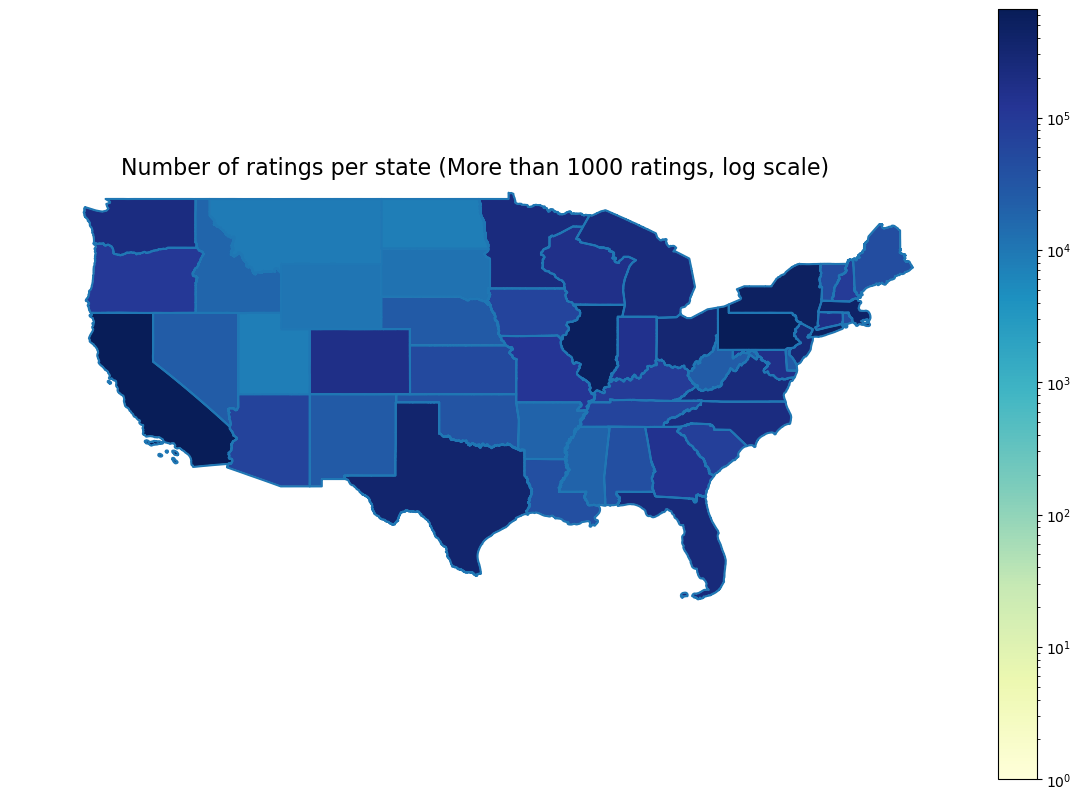

In [25]:
shapefile_path = r'.\src\data\tl_2024_us_state\tl_2024_us_state.shp'
us = gpd.read_file(shapefile_path)

# Merge your ratings data with the world GeoDataFrame
merged = us.merge(nbr_ratings_per_location, how='left', left_on='NAME', right_on='states')

# Fill NaN values in 'nbr_ratings' with 0 for visualization
merged['nbr_ratings'] = merged['nbr_ratings'].fillna(0)

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax)  # Plot the world boundaries
merged.plot(column='nbr_ratings', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', 
            norm=LogNorm(vmin=1, vmax=merged['nbr_ratings'].max()), legend=True)

# Customizing the plot
ax.set_title('Number of ratings per state (More than 1000 ratings, log scale)', fontsize=16)
ax.set_xlim([-130, -65])  # x-limits (longitude) for US (adjust for specific areas)
ax.set_ylim([24, 50])
ax.set_axis_off()  # Turn off the axis
plt.show()

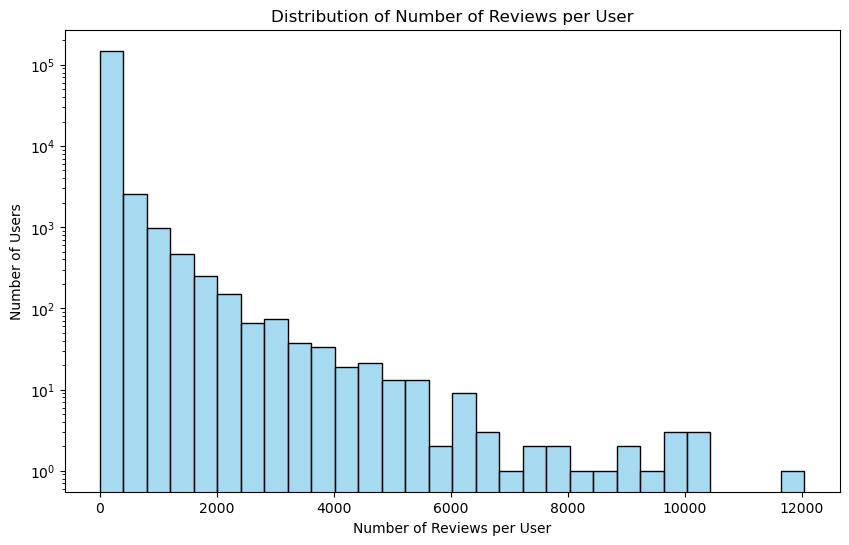

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(ba_users_df['nbr_ratings'], bins=30, kde=False, color="skyblue")  # Adjust bins as needed
plt.xlabel('Number of Reviews per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Reviews per User')
plt.yscale('log')  # Optional: Log scale for better visualization if skewed
plt.show()

<h1 style="font-size: 30px;">1.2: Beer styles popularity</h1>

In this section we focus on showing which beer tend to be more popular over the years. We show that IPA has increased in popularity!

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\472806417.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_counts.values, y=style_counts.index, palette="viridis")


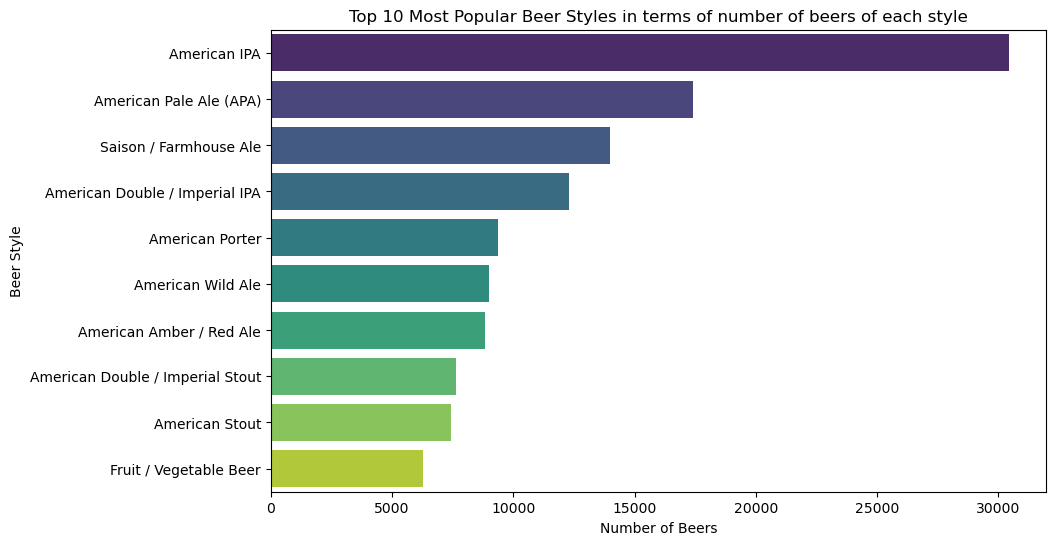

In [27]:
style_counts = ba_beers_df['style'].value_counts().head(10)  # Top 10 beer styles

plt.figure(figsize=(10,6))
sns.barplot(x=style_counts.values, y=style_counts.index, palette="viridis")
plt.title("Top 10 Most Popular Beer Styles in terms of number of beers of each style")
plt.xlabel("Number of Beers")
plt.ylabel("Beer Style")
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\767345401.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_counts_ratings, y=style_counts_ratings.index.tolist(), palette="viridis")


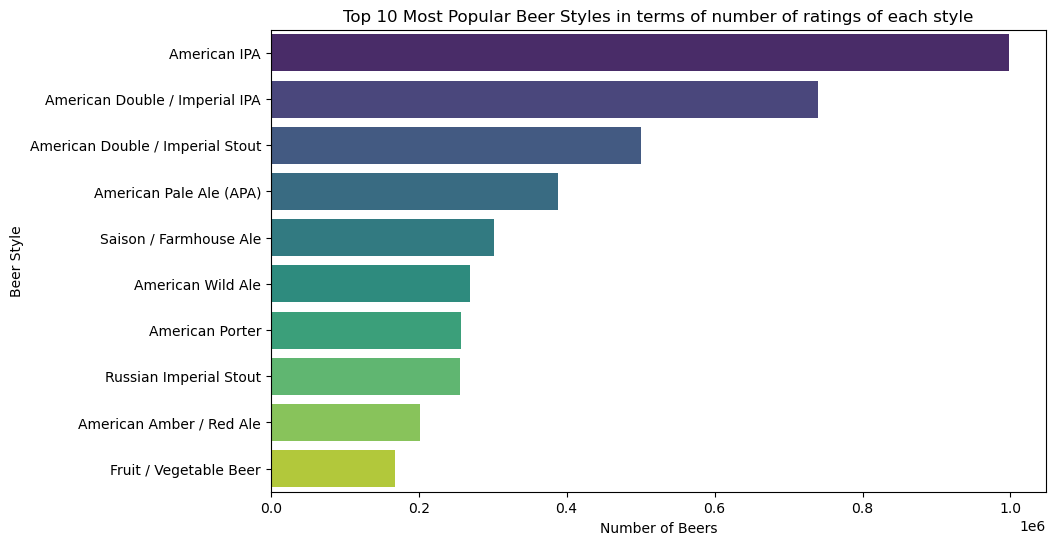

In [28]:
style_counts_ratings = ba_ratings_df['style'].dropna().value_counts().sort_values(ascending=False).head(10)  # Top 10 beer styles

plt.figure(figsize=(10,6))
sns.barplot(x=style_counts_ratings, y=style_counts_ratings.index.tolist(), palette="viridis")
plt.title("Top 10 Most Popular Beer Styles in terms of number of ratings of each style")
plt.xlabel("Number of Beers")
plt.ylabel("Beer Style")
plt.show()

Here we merge the different dataframes in order to work with them

In [29]:
users_df_selected = ba_users_df[['user_id', 'location']]
ratings_df_selected = ba_ratings_df[['user_id', 'brewery_id', 'style', 'abv', 'appearance', 'aroma', 'palate', 'rating', 'taste', 'date']]

# Merging on 'user_id'
#Contains the ratings and the location of the users
merged_df = pd.merge(users_df_selected, ratings_df_selected, on='user_id', how='right')

ba_breweries_df.rename(columns={'location': 'brewery_location'}, inplace=True)
ba_breweries_df.rename(columns={'id': 'brewery_id'}, inplace=True)

ba_breweries_selected = ba_breweries_df[['brewery_id', 'brewery_location', 'nbr_beers']]

# Perform the merge on `beer_id`
#Contains the ratings, the location of the users and the location of the breweries
final_merged_df = pd.merge(merged_df, ba_breweries_selected, on='brewery_id', how='inner')
#[8393032 rows x 11 columns]

Here we define the styles that correspond to the IPA

In [30]:
# Assuming final_merged_df is your DataFrame
# Get unique styles from the 'style' column
unique_styles = final_merged_df['style'].unique()

# Print the unique styles
print(unique_styles)

macro_group = {
    'IPA': ['American IPA', 'English India Pale Ale (IPA)', 'Belgian IPA', 'American Double / Imperial IPA']
}

['Euro Pale Lager', 'English Pale Ale', 'English Bitter', 'American Pale Wheat Ale', 'American Blonde Ale', ..., 'Lambic - Unblended', 'Bière de Champagne / Bière Brut', 'Japanese Rice Lager', 'Happoshu', 'Faro']
Length: 104
Categories (104, object): ['Altbier', 'American Amber / Red Ale', 'American Amber / Red Lager', 'American Barleywine', ..., 'Lambic - Unblended', 'Happoshu', 'Japanese Rice Lager', 'Faro']


In [31]:
final_merged_df['datetime'] = pd.to_datetime(final_merged_df['date'], unit='s')

# Extract the year from the datetime
final_merged_df['year'] = final_merged_df['datetime'].dt.year
# Extract the month from the datetime
final_merged_df['month'] = final_merged_df['datetime'].dt.month
#Delete unused columns
final_merged_df = final_merged_df.drop('datetime', axis=1)
final_merged_df = final_merged_df.drop('date', axis=1)

def categorize_macro_group(style):
    for key, styles in macro_group.items():
        if style in styles:
            return key
    return 'Other'

final_merged_df['macro_group'] = final_merged_df['style'].apply(categorize_macro_group)

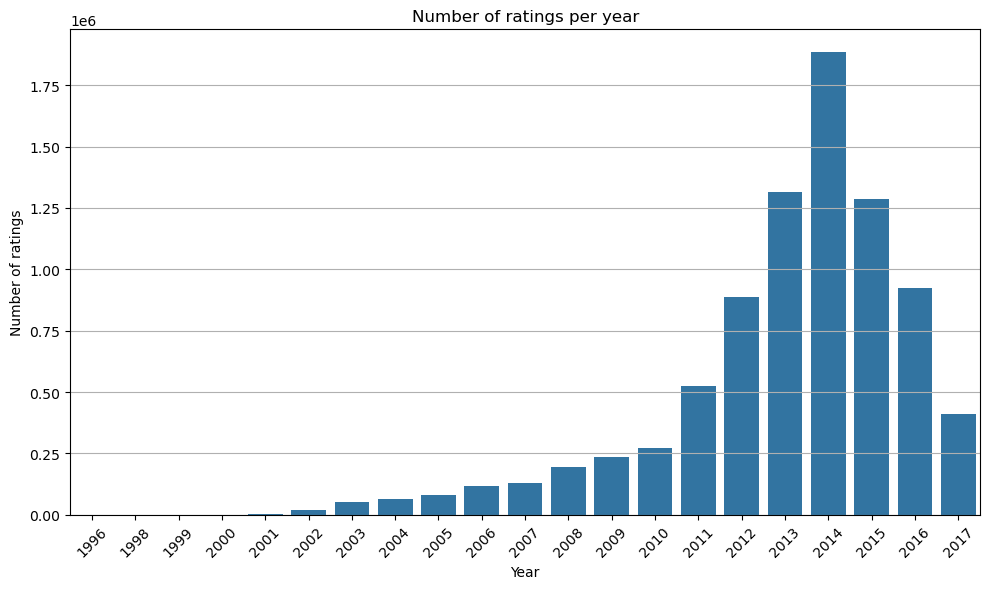

In [32]:
per_year = final_merged_df.groupby(['year']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=per_year, x='year', y='count')
plt.title('Number of ratings per year')
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


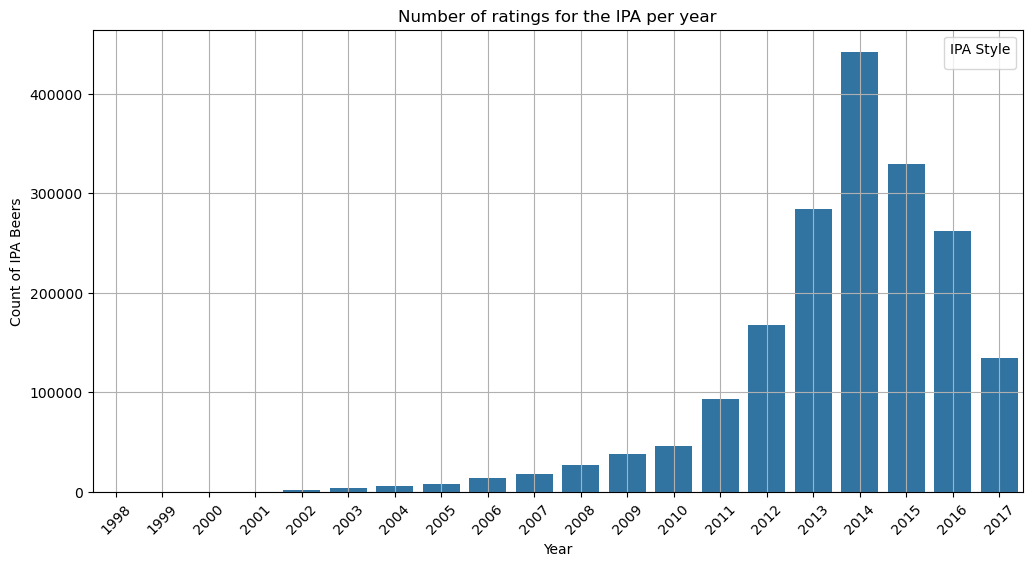

In [35]:
per_year_IPA_total = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=per_year_IPA_total, x='year', y='count')

# Customize the plot
plt.title('Number of ratings for the IPA per year')
plt.xlabel('Year')
plt.ylabel('Count of IPA Beers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='IPA Style')  # Add a legend to differentiate IPA styles
plt.grid(True)
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\1053538180.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_year_IPA = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year', 'style']).size().reset_index(name='count')


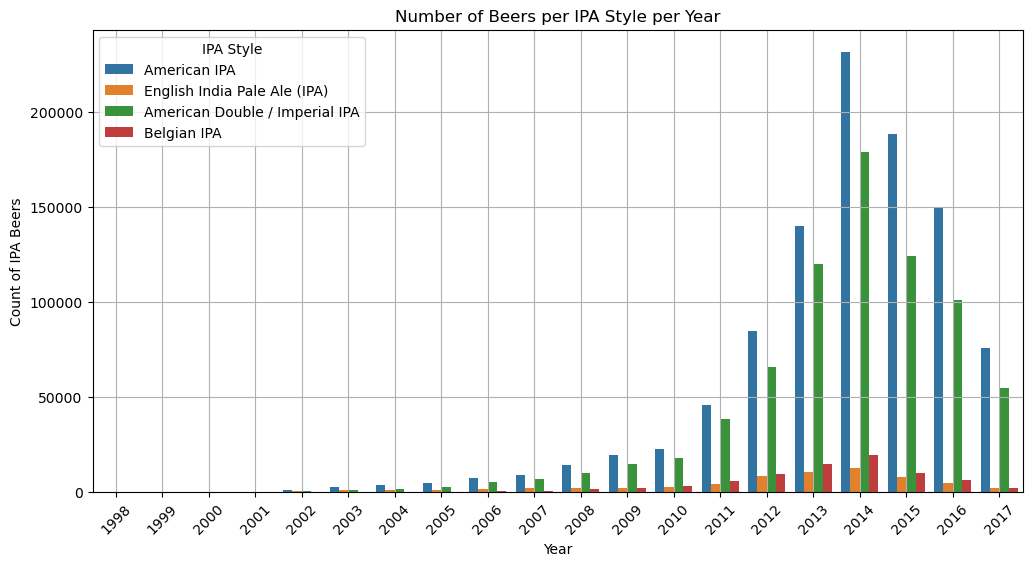

In [37]:
# Group by 'year' and 'macro_group' (IPA style) and count occurrences
per_year_IPA = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year', 'style']).size().reset_index(name='count')
per_year_IPA = per_year_IPA[(per_year_IPA['count'] > 0)]
per_year_IPA = per_year_IPA.set_index('style')

# Plotting the data with one bar per IPA style for each year
plt.figure(figsize=(12, 6))
sns.barplot(data=per_year_IPA, x='year', y='count', hue=per_year_IPA.index.tolist())

# Customize the plot
plt.title('Number of Beers per IPA Style per Year')
plt.xlabel('Year')
plt.ylabel('Count of IPA Beers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='IPA Style')  # Add a legend to differentiate IPA styles
plt.grid(True)
plt.show()


From now on, we exclude the years before 2008 everytime we try to show a temporal evolution for the rest of step 1

In [59]:
#We decided to keep only the years after 2007 for our analysis over the years:
final_merged_df = final_merged_df[final_merged_df['year'] >= 2008]

In [52]:
#Here we compute the percentage of beer beeing IPA per year

#We first group by year and IPA/Not IPA
grouped = final_merged_df.groupby(['year', 'macro_group']).size().reset_index(name='count')

# Group by year to get total counts
total_count_per_year = final_merged_df.groupby('year').size().reset_index(name='total_count')

# Merge the counts with total counts
merged = pd.merge(grouped, total_count_per_year, on='year')

# Calculate the percentage
merged['percentage'] = (merged['count'] / merged['total_count']) * 100

# Filter to show only the macro group 'IPA'
result = merged[merged['macro_group'] == 'IPA'][['year', 'count', 'total_count', 'percentage']]

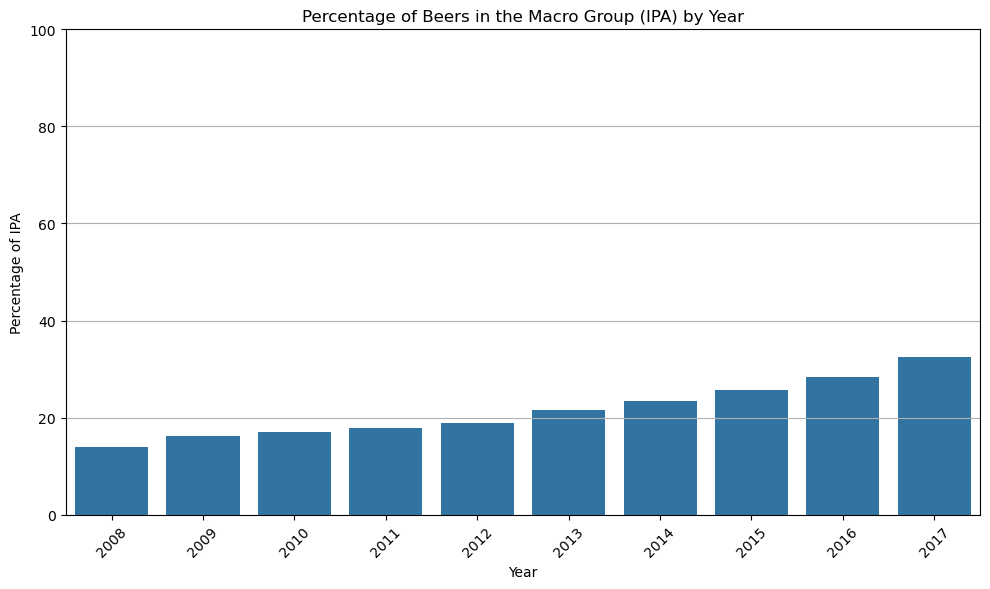

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result, x='year', y='percentage')
plt.title('Percentage of Beers in the Macro Group (IPA) by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of IPA')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y')  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

<h1 style="font-size: 30px;">1.3: IPA top Beer?</h1>

In this section, we check if one of the IPA style was always present as the top beer for one country. We here excluded the years before 2008 and the countries/US states with less than 1000 ratings, trying to focus on meaningful data

In [60]:
def filter_location(min_ratings, final_merged_df):
    location_ratings = final_merged_df.groupby('location').count()

    # Filter locations with more than 1000 ratings
    locations_over_min = location_ratings[location_ratings['rating'] > min_ratings].index

    # Filter the original DataFrame to include only these locations
    return final_merged_df[final_merged_df['location'].isin(locations_over_min)]

location_df = filter_location(1000, final_merged_df)
beer_counts = location_df.groupby(['location', 'year', 'style']).size().reset_index(name='count')

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\2995714371.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beer_counts = location_df.groupby(['location', 'year', 'style']).size().reset_index(name='count')


In [61]:
#For each year and location, give a rank for each beer styles. For example if Altbier has the most ratings for 2006 in Australia,
#we assign it as rank 1
beer_counts['rank'] = beer_counts.groupby(['location', 'year'])['count'].rank(method='first', ascending=False)

In [62]:
#For each year and location, it gives the most rated beer
top_styles = beer_counts[beer_counts['rank'] <= 1]

# Sort the result for easier readability
#This gives the top beers per year and per location
top_styles = top_styles.sort_values(['location', 'year', 'rank'])

In [63]:
#is_IPA is true if for a given location and given year, the best beer is an IPA
top_styles['is_IPA'] = top_styles['style'].isin(macro_group['IPA'])

# For each year and location, check if there's an IPA style (useful only if we want the top 3 instead of top 1 for example)
ipa_presence = (
    top_styles.groupby(['location', 'year'])['is_IPA']
    .any()  # Check if there's any IPA style in each group  # Replace True/False with Yes/No
    .reset_index(name='IPA_Present')  # Reset index and name the column
)

In [64]:
def compute_best_countries_per_year(ipa_presence):

    #Check if for all countries the 10 years range is present
    check_countries = ipa_presence.groupby('location').count().reset_index()

    #Print the total number of countries
    total_countries = ipa_presence['location'].nunique()

    # Filter for rows where IPA_Present is "Yes"
    ipa_countries = ipa_presence[ipa_presence['IPA_Present'] == True]

    # Group by year and count unique locations
    #This gives the number of countries that have as the best beer beeing an IPA per year
    ipa_presence_count = ipa_countries.groupby('year')['location'].nunique().reset_index(name='num_countries_with_IPA')

    return ipa_presence_count, total_countries, 

ipa_presence_count, total_countries = compute_best_countries_per_year(ipa_presence)

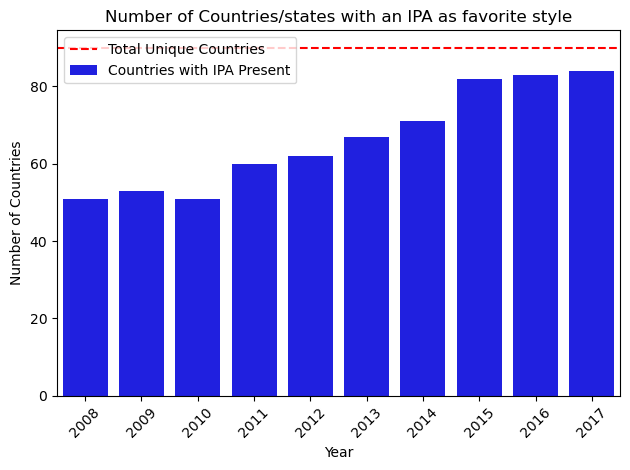

In [65]:
# Bar plot for the number of countries with IPA
sns.barplot(x='year', y='num_countries_with_IPA', data=ipa_presence_count, color='blue', label='Countries with IPA Present')

# Adding a line plot for total countries (this will be a constant line across years)
plt.axhline(y=total_countries, color='red', linestyle='--', label='Total Unique Countries')

# Customize the plot
plt.title('Number of Countries/states with an IPA as favorite style')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

<h1 style="font-size: 30px;">1.4: Ratings of the IPA</h1>

We here checked if the ratings for the IPA tend to be better than the ratings for other beers. We do this over the years (starting 2008) and over locations (with more than 1000 ratings)

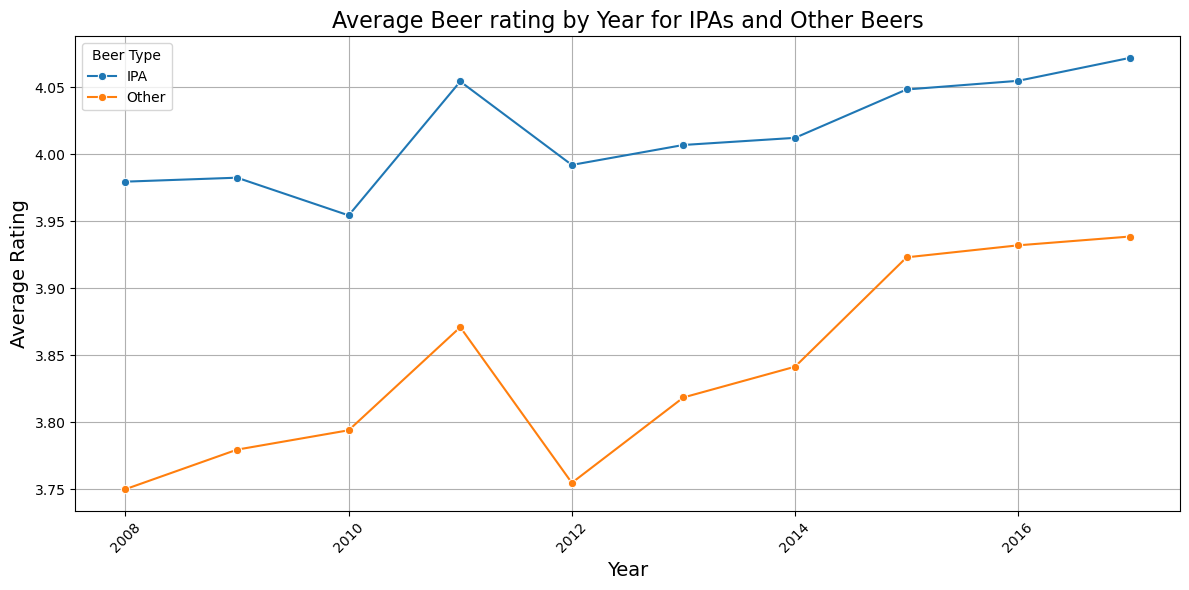

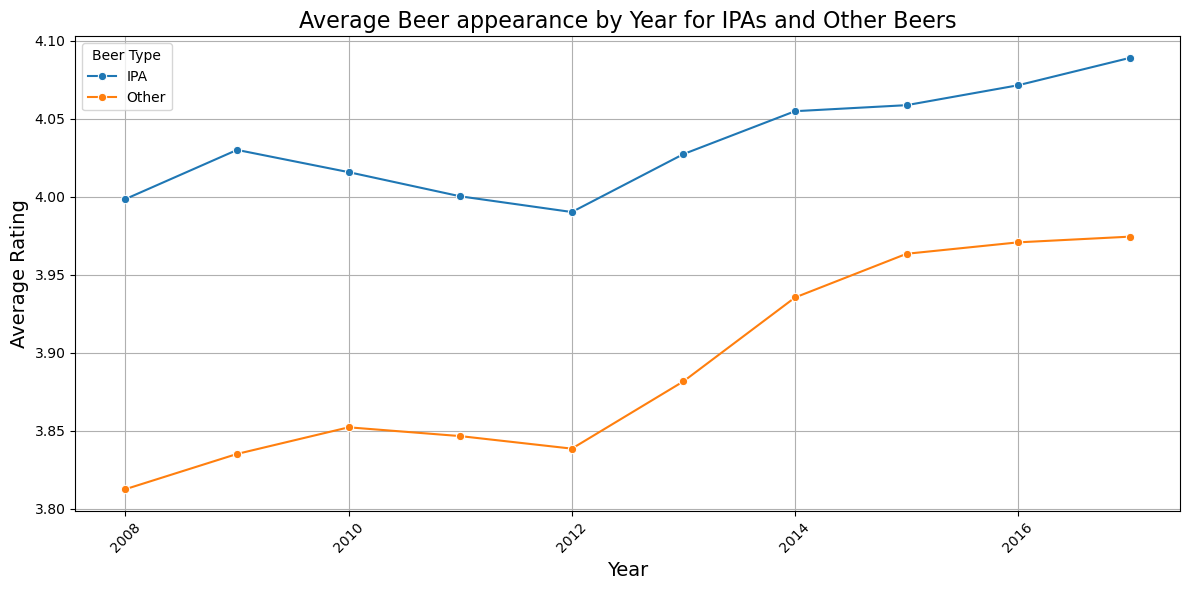

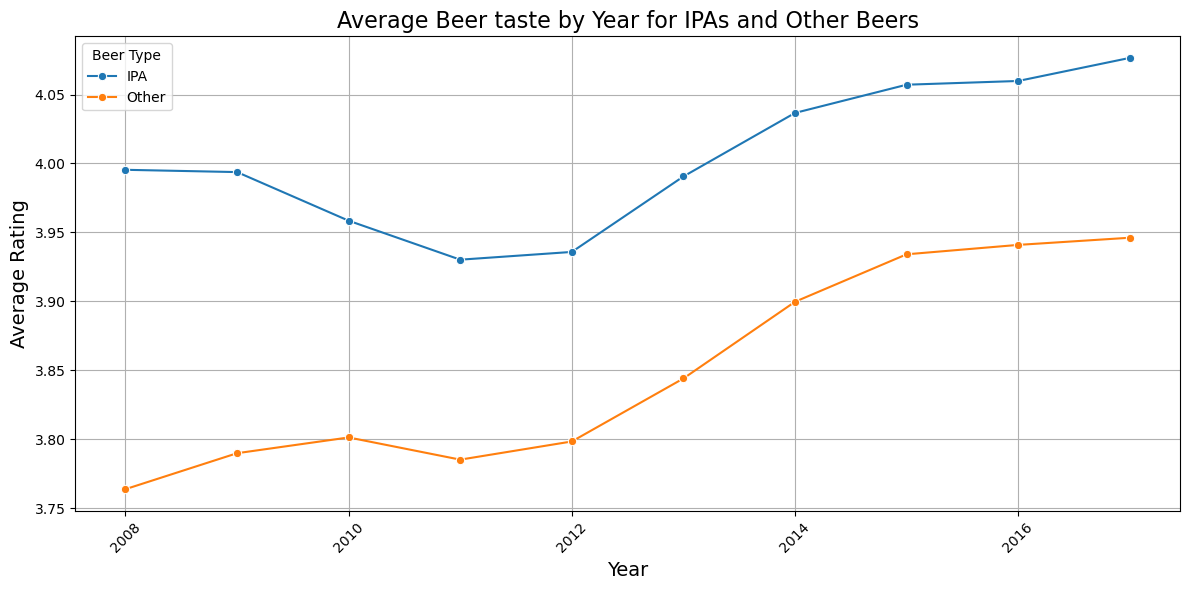

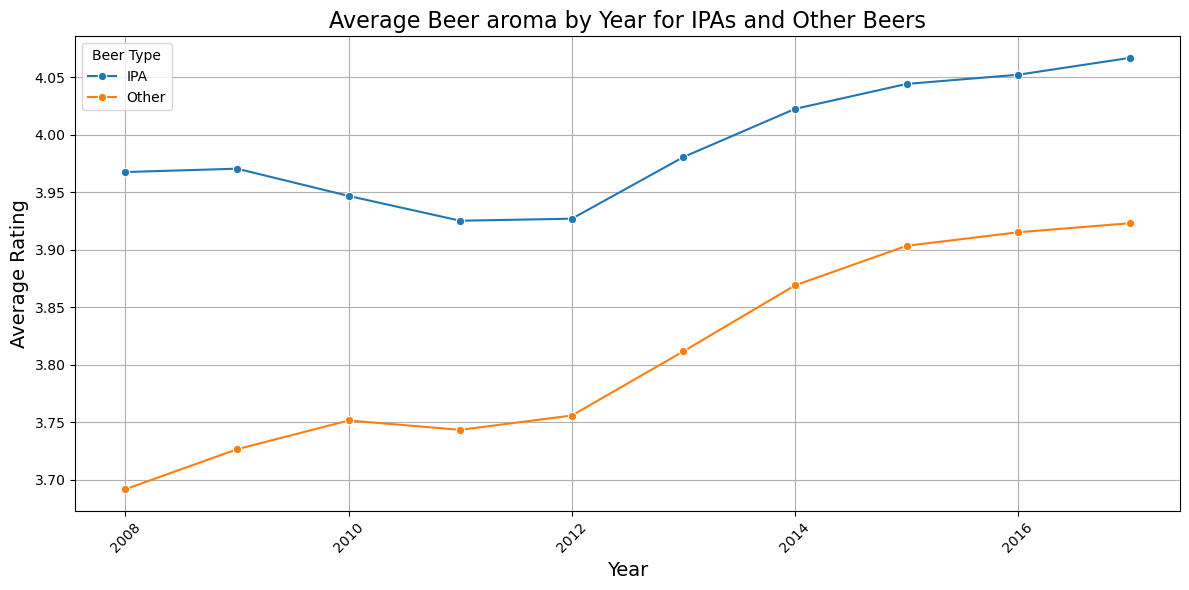

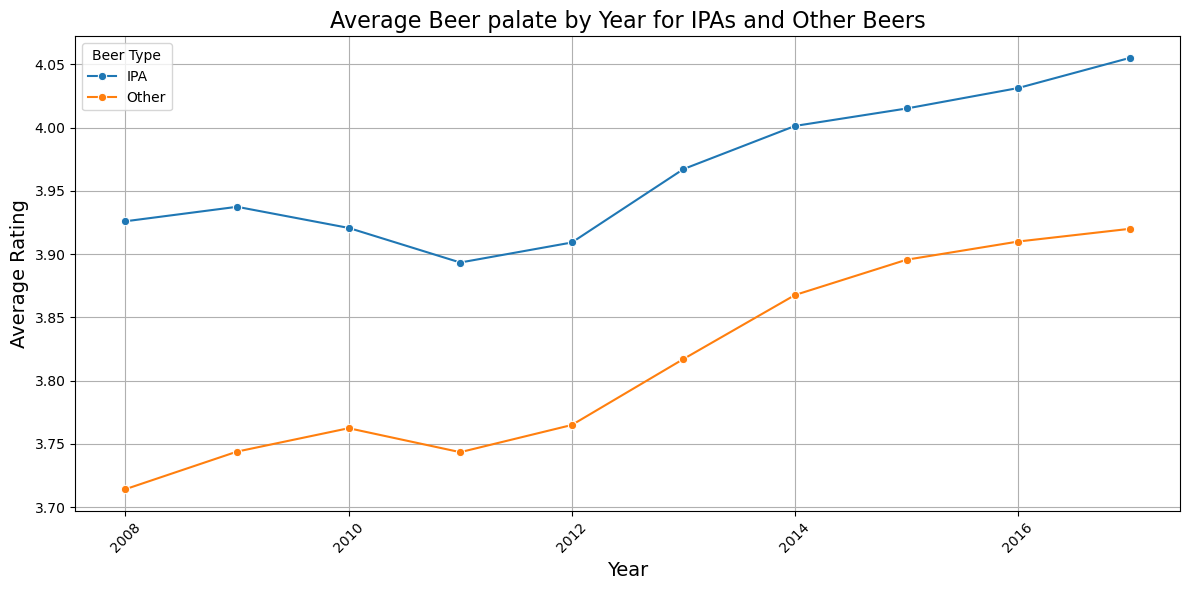

In [68]:
def envolve_rating(rating_kind):
    average_ratings = final_merged_df.groupby(['year', 'macro_group'])[rating_kind].mean().reset_index()
    average_ratings.rename(columns={rating_kind: 'average_rating'}, inplace=True)
    #print(average_ratings)
    plt.figure(figsize=(12, 6))

    # Create a line plot for average ratings
    sns.lineplot(data=average_ratings, x='year', y='average_rating', hue='macro_group', marker='o')

    # Customize the plot
    plt.title(f'Average Beer {rating_kind} by Year for IPAs and Other Beers', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Rating', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='Beer Type')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()
#apperance, taste, aroma, palate, rating
envolve_rating('rating')
envolve_rating('appearance')
envolve_rating('taste')
envolve_rating('aroma')
envolve_rating('palate')

**Is that true that every country rates better IPAs than other beers?**

In [69]:
#Just for here, we take locations with at least 5000 ratings
filtered_df = filter_location(5000, final_merged_df)
average_ratings = filtered_df.groupby(['location', 'macro_group'])['rating'].mean().reset_index()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\623373294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_states['states'] = american_states['location'].apply(clean_states)


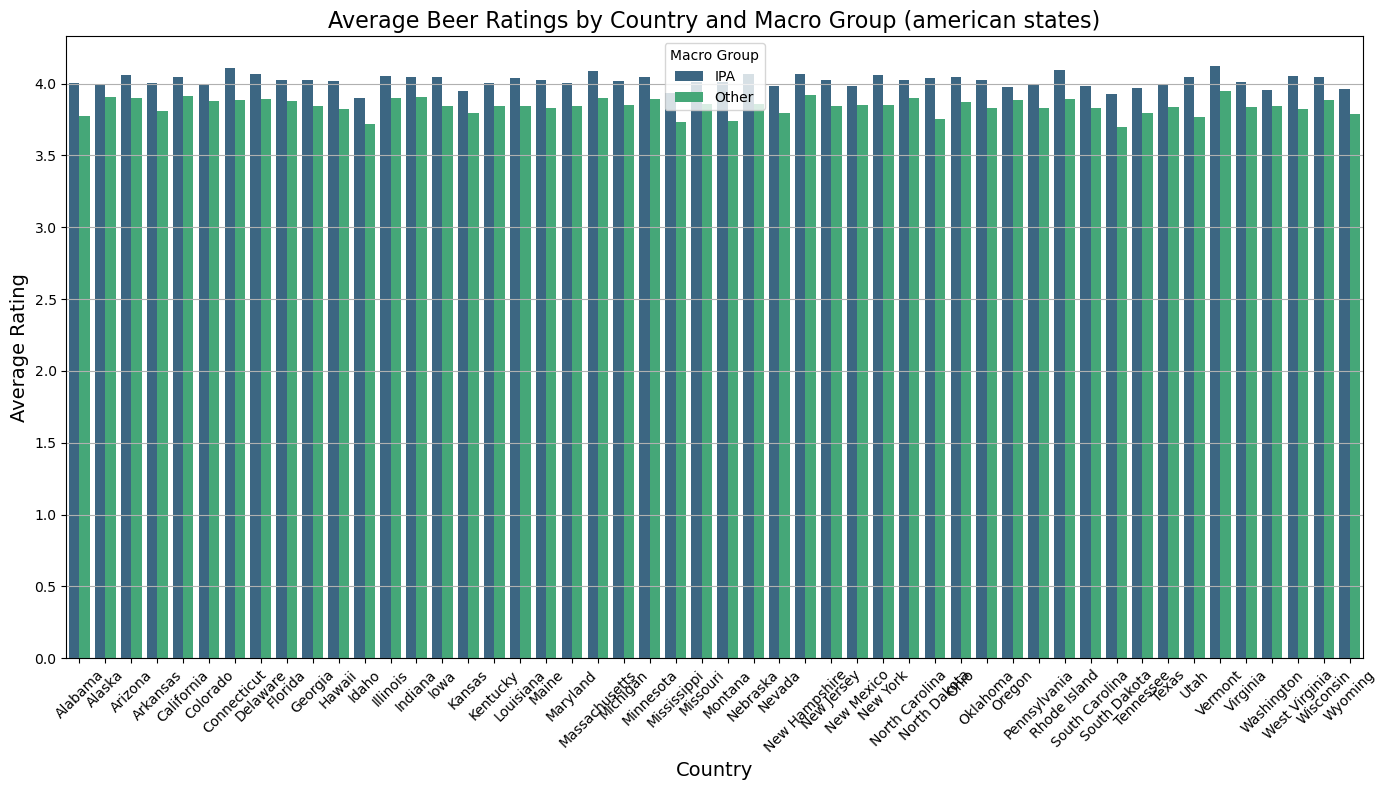

In [70]:
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

american_states = average_ratings[average_ratings['location'].str.startswith("United States")]
non_american_states = average_ratings[~average_ratings['location'].str.startswith("United States")]

american_states['states'] = american_states['location'].apply(clean_states)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(data=american_states, x='states', y='average_rating', hue='macro_group', palette='viridis')

# Customize the plot
plt.title('Average Beer Ratings by Country and Macro Group (american states)', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Macro Group')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

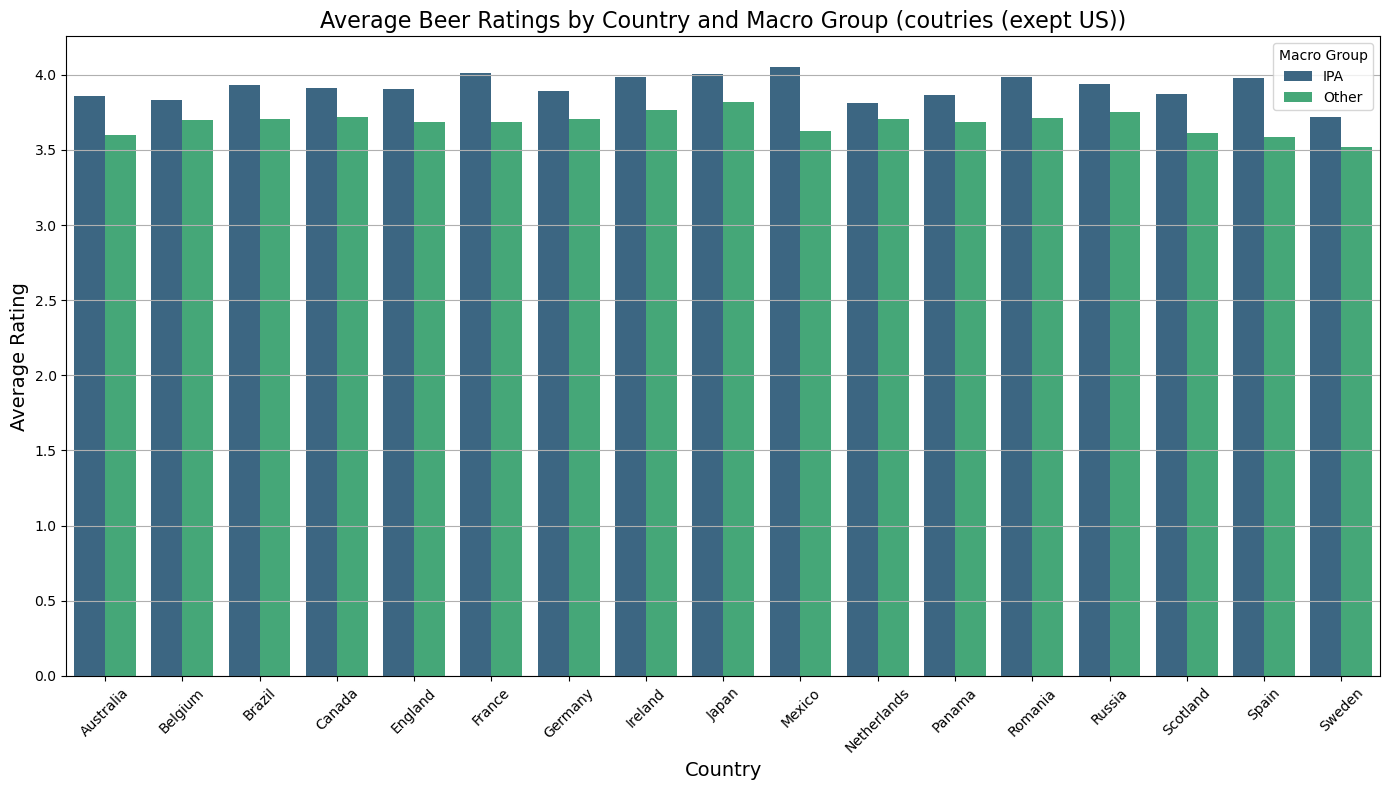

In [71]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(data=non_american_states, x='location', y='average_rating', hue='macro_group', palette='viridis')

# Customize the plot
plt.title('Average Beer Ratings by Country and Macro Group (coutries (exept US))', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Macro Group')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

<h1 style="font-size: 30px;">1.5: Big or small raters?</h1>

We here investigate if big or small raters (in terms of number of ratings per user) rent beers (and IPA) differently from each other.
A big rater is defined as rating more than "number_ratings = 500" beers

In [72]:
user_rating_counts = final_merged_df.groupby('user_id')['rating'].count().reset_index()
user_rating_counts.columns = ['user_id', 'rating_count']  # Rename columns for clarity

In [73]:
number_ratings = 500
users_above = user_rating_counts[user_rating_counts['rating_count'] > number_ratings]
users_below = user_rating_counts[user_rating_counts['rating_count'] <= number_ratings]

In [78]:
#Seperate the dataframe final_merged_df between big and small users
big_users = final_merged_df[final_merged_df['user_id'].isin(users_above['user_id'])]
small_users = final_merged_df[final_merged_df['user_id'].isin(users_below['user_id'])]

In [79]:
#Compute the avg rating for IPA and Other for big and small users
big_avg_ratings = big_users.groupby('macro_group')['rating'].mean().reset_index()
small_avg_ratings = small_users.groupby('macro_group')['rating'].mean().reset_index()
avg_ratings = pd.merge(big_avg_ratings, small_avg_ratings, on='macro_group', suffixes=('_big', '_small'))
avg_ratings.columns = ['beer_type', 'big_users', 'small_users']
print(avg_ratings)

  beer_type  big_users  small_users
0       IPA   3.951986     4.103359
1     Other   3.822330     3.885438


  beer_type   user_group  average_rating
0       IPA    big_users        3.951986
1     Other    big_users        3.822330
2       IPA  small_users        4.103359
3     Other  small_users        3.885438


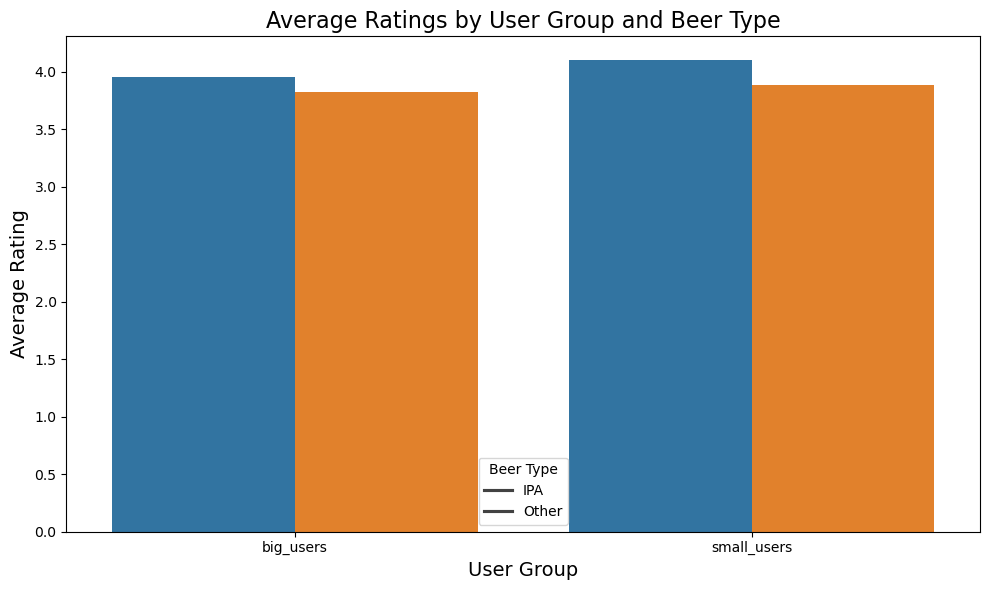

In [80]:
avg_ratings_melted = avg_ratings.melt(id_vars='beer_type', 
                                        value_vars=['big_users', 'small_users'],
                                        var_name='user_group', 
                                        value_name='average_rating')

print(avg_ratings_melted)

# Create a bar plot with user groups on the x-axis
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_ratings_melted, x='user_group', y='average_rating', hue='beer_type')

# Add titles and labels
plt.title('Average Ratings by User Group and Beer Type', fontsize=16)
plt.xlabel('User Group', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=0)  # No rotation needed for x-axis labels
plt.legend(title='Beer Type', labels=['IPA', 'Other'])
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()

<h1 style="font-size: 30px;">1.6: IPA popularity per country</h1>

We here investigate which countries tend to rate more often IPAs than other beers. We focus here again with location with at least 5000 ratings.

In [81]:
filtered_df_copy = filter_location(5000, final_merged_df).copy()
filtered_df_copy['is_IPA'] = filtered_df_copy['style'].isin(macro_group['IPA'])

In [84]:
#Compute percentage of beers beeing rated that are IPA per location
location_ipa_percentage = filtered_df_copy.groupby('location').agg(
    IPA_Percentage=('is_IPA', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

location_ipa_percentage_sorted = location_ipa_percentage.sort_values(by='IPA_Percentage', ascending=False)

In [85]:
#Distinguish between US states and country
american_states = location_ipa_percentage_sorted[location_ipa_percentage_sorted['location'].str.startswith("United States")]
non_american_states = location_ipa_percentage_sorted[~location_ipa_percentage_sorted['location'].str.startswith("United States")]

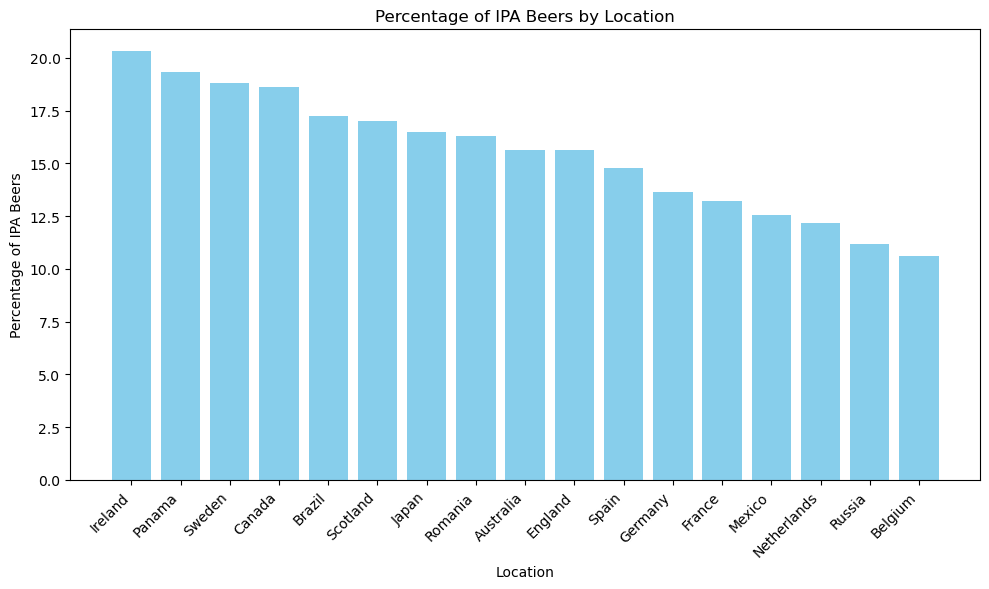

In [86]:
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(non_american_states['location'], non_american_states['IPA_Percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage of IPA Beers')
plt.title('Percentage of IPA Beers by Location')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\1220279976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_states['states'] = american_states['location'].apply(clean_states)


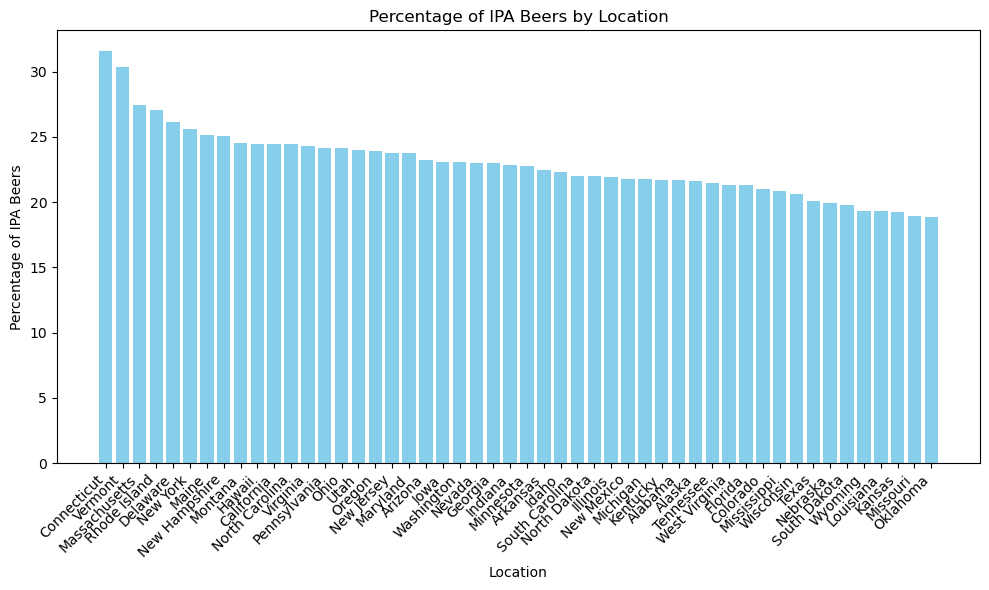

In [87]:
american_states['states'] = american_states['location'].apply(clean_states)
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(american_states['states'], american_states['IPA_Percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage of IPA Beers')
plt.title('Percentage of IPA Beers by Location')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

<h1 style="font-size: 30px;">1.7: Big or small breweries</h1>

We here investigate if IPA tend to be brewed by smaller of bigger breweries

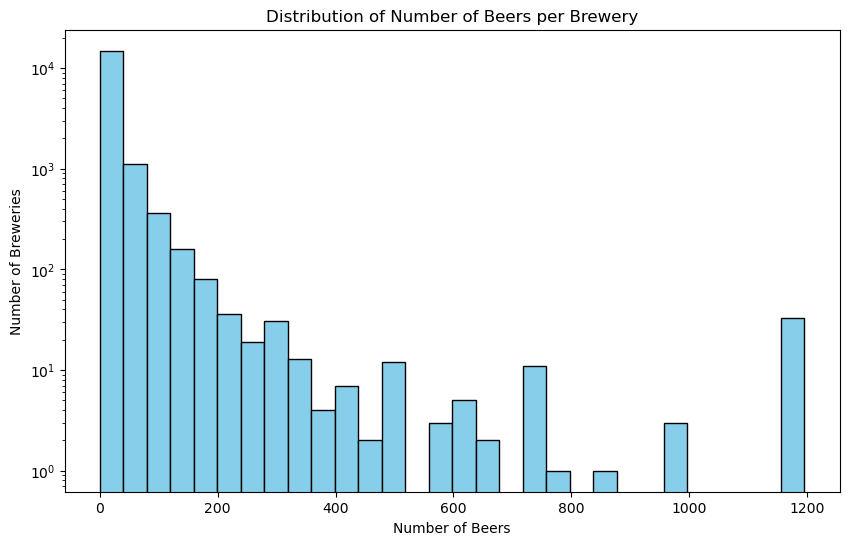

In [88]:
plt.figure(figsize=(10, 6))
plt.hist(ba_breweries_df['nbr_beers'], bins=30, color='skyblue', edgecolor='black', log=True)
plt.title('Distribution of Number of Beers per Brewery')
plt.xlabel('Number of Beers')
plt.ylabel('Number of Breweries')
plt.show()

In [90]:
merged_df_brew = pd.merge(ba_beers_df, ba_breweries_df, left_on='brewery_id', right_on='brewery_id', how='left')
merged_df_brew['is_IPA'] = merged_df_brew['style'].isin(macro_group['IPA'])

In [91]:
#Compute avg brewery size (in terms of number of brewed beer) per IPA/non IPA
average_beers_by_brewery = merged_df_brew.groupby(['is_IPA'])['nbr_beers'].mean().reset_index()
print(average_beers_by_brewery)

   is_IPA   nbr_beers
0   False   99.687014
1    True  112.922218


In [92]:
#Let's say that a big brewery is a brewery brewing more than 200 beers. Let's see how many ratings
#come from small or big breweries depending if it's an IPA or not
final_merged_df['big_brewery'] = final_merged_df['nbr_beers'] > 200
grouped_df = final_merged_df.groupby(['macro_group', 'big_brewery']).size().reset_index(name='count')

In [93]:
ipa_count = grouped_df[(grouped_df['macro_group'] == 'IPA') & (grouped_df['big_brewery'] == False)]['count'].values[0]
big_brewery_count = grouped_df[(grouped_df['macro_group'] == 'IPA') & (grouped_df['big_brewery'] == True)]['count'].values[0]

# Performing the calculation
result = big_brewery_count / (ipa_count + big_brewery_count)*100

# Printing the result
print("Percentage big brewery for IPA = ", result)

Percentage big brewery for IPA =  45.31852657476214


In [94]:
non_ipa_count = grouped_df[(grouped_df['macro_group'] == 'Other') & (grouped_df['big_brewery'] == False)]['count'].values[0]
non_ipa_big_brewery_count = grouped_df[(grouped_df['macro_group'] == 'Other') & (grouped_df['big_brewery'] == True)]['count'].values[0]

# Performing the calculation
result = non_ipa_big_brewery_count / (non_ipa_count + non_ipa_big_brewery_count)*100

# Printing the result
print("Percentage big brewery for IPA = ", result)

Percentage big brewery for IPA =  33.29407386706234


In [95]:
grouped_df = final_merged_df.groupby(['year', 'macro_group', 'big_brewery']).size().reset_index(name='count')
print(grouped_df)

    year macro_group  big_brewery   count
0   2008         IPA        False   15083
1   2008         IPA         True   11960
2   2008       Other        False  125183
3   2008       Other         True   42628
4   2009         IPA        False   19073
5   2009         IPA         True   18829
6   2009       Other        False  139956
7   2009       Other         True   55395
8   2010         IPA        False   24587
9   2010         IPA         True   21435
10  2010       Other        False  154961
11  2010       Other         True   70001
12  2011         IPA        False   46752
13  2011         IPA         True   46652
14  2011       Other        False  280004
15  2011       Other         True  150851
16  2012         IPA        False   79419
17  2012         IPA         True   88498
18  2012       Other        False  476716
19  2012       Other         True  243858
20  2013         IPA        False  131306
21  2013         IPA         True  153071
22  2013       Other        False 

We here check the evolution during time to see if users tend to rate beers from small/big breweries and how it changes between IPA/Non IPA

macro_group        IPA      Other
year                             
2008         44.225863  25.402387
2009         49.678117  28.356650
2010         46.575551  31.116811
2011         49.946469  35.012011
2012         52.703419  33.842187
2013         53.826786  35.432520
2014         48.903474  34.754541
2015         40.540385  32.598619
2016         35.753897  31.685160
2017         31.937071  29.945491


<Figure size 1000x600 with 0 Axes>

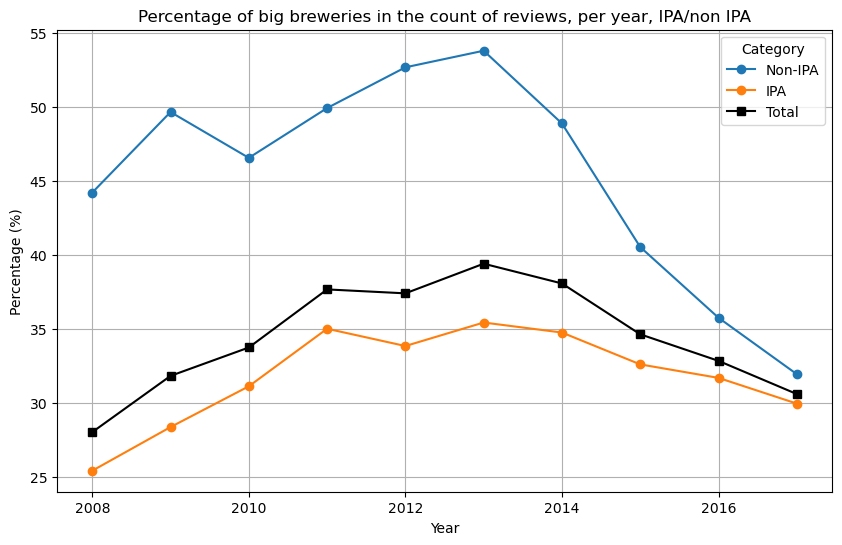

In [96]:
total_counts = grouped_df.groupby(['year', 'macro_group'])['count'].sum().unstack()

# Calculate counts of IPA and non-IPA from big breweries
big_brewery_counts = grouped_df[grouped_df['big_brewery'] == True].groupby(['year', 'macro_group'])['count'].sum().unstack()

# Calculate percentage of IPA and non-IPA from big breweries
percentage_big_brewery = big_brewery_counts.div(total_counts) * 100

#For each year we'll have 
print(percentage_big_brewery)

# Calculate the total beer counts from big breweries and total beer counts for each year
total_big_brewery_counts = grouped_df[grouped_df['big_brewery'] == True].groupby('year')['count'].sum()
total_all_counts = grouped_df.groupby('year')['count'].sum()

# Calculate the total percentage of all beer from big breweries
percentage_total_big_brewery = total_big_brewery_counts.div(total_all_counts) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot the percentage of IPA, non-IPA, and total from big breweries
percentage_big_brewery.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6))
plt.plot(percentage_total_big_brewery, marker='s', linestyle='-', color='black', label='Total Big Brewery')

# Adding labels and title
plt.title('Percentage of big breweries in the count of reviews, per year, IPA/non IPA')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(title='Category', labels=['Non-IPA', 'IPA', 'Total'])

# Display the plot
plt.grid(True)
plt.show()

<h1 style="font-size: 30px;">1.8: Is IPA a seasonal beer?</h1>

We here investigate if the IPA is a seasonal beer. Namely, we try to see if the percentage of IPA compared to other beers is higher during the summer/winter. As previously stated, even if a trend seems to appear, we still need to check if this one is statistically significant. 

In [97]:
per_month_df = final_merged_df.groupby('month')['rating'].size().reset_index()
per_month_df = per_month_df.rename(columns={
    'month': 'Month',
    'rating': 'Number of Ratings'
})

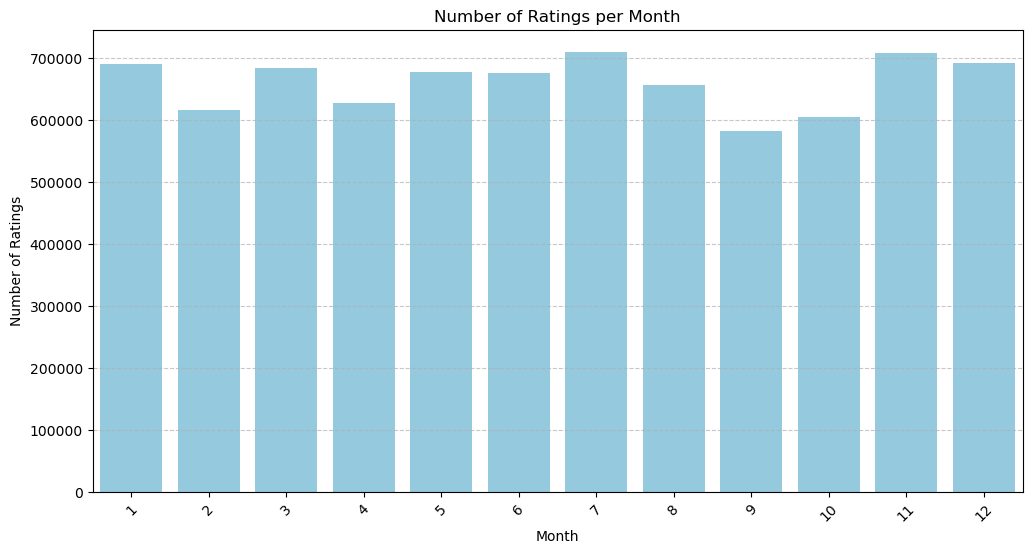

In [98]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', color='skyblue')

# Customize the plot
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [99]:
per_month_df = final_merged_df.groupby(['month', 'macro_group'])['rating'].size().reset_index()
per_month_df = per_month_df.rename(columns={
    'month': 'Month',
    'rating': 'Number of Ratings'
})

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\1692377028.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', hue='macro_group', color='skyblue')


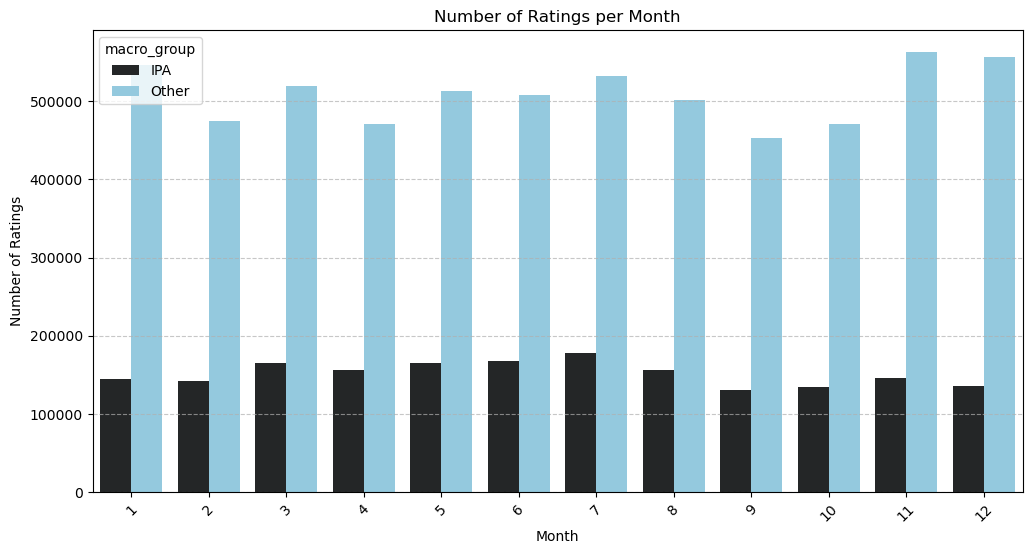

In [100]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', hue='macro_group', color='skyblue')

# Customize the plot
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

Here we compute the percentage of IPA per month instead of the absolute values

In [102]:
monthly_totals = per_month_df.groupby('Month')['Number of Ratings'].sum().reset_index(name='Total Ratings')

# Merge monthly totals back into the original DataFrame
df = pd.merge(per_month_df, monthly_totals, on='Month')

# Calculate IPA percentage
df['IPA Percentage'] = df.apply(lambda row: (row['Number of Ratings'] / row['Total Ratings']) * 100 
                                if row['macro_group'] == 'IPA' else None, axis=1)

# Drop rows with None in 'IPA Percentage' to only keep IPA rows
ipa_percentages = df.dropna(subset=['IPA Percentage'])[['Month', 'IPA Percentage']]

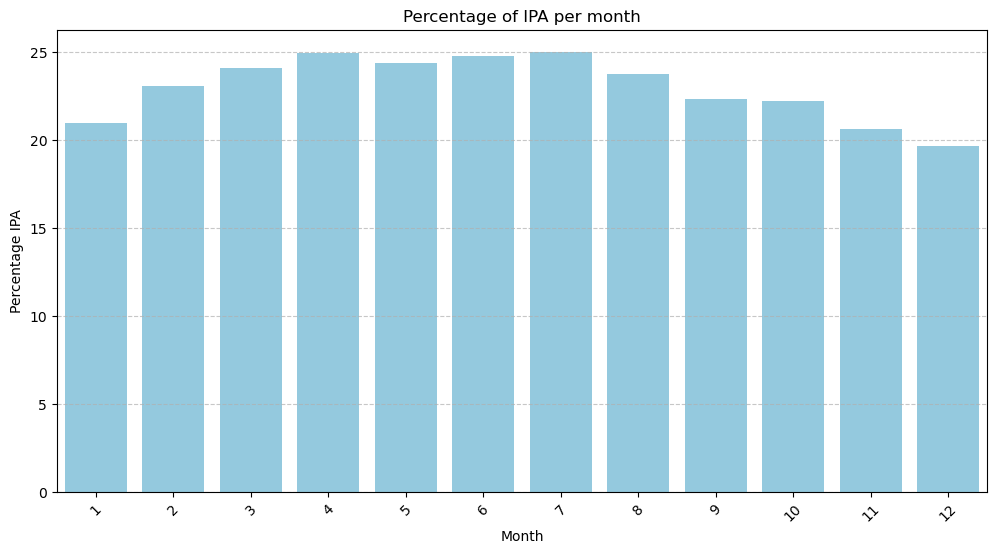

In [103]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=ipa_percentages, x='Month', y='IPA Percentage', color='skyblue')

# Customize the plot
plt.title('Percentage of IPA per month')
plt.xlabel('Month')
plt.ylabel('Percentage IPA')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

<h1 style="font-size: 30px;">1.9: Does IPA contain more alcohol? </h1>

In this section we try to understand if there is an evolution over the years on how much alcohol contain the beers of the users if the rated IPAs contain more ABV than other beers

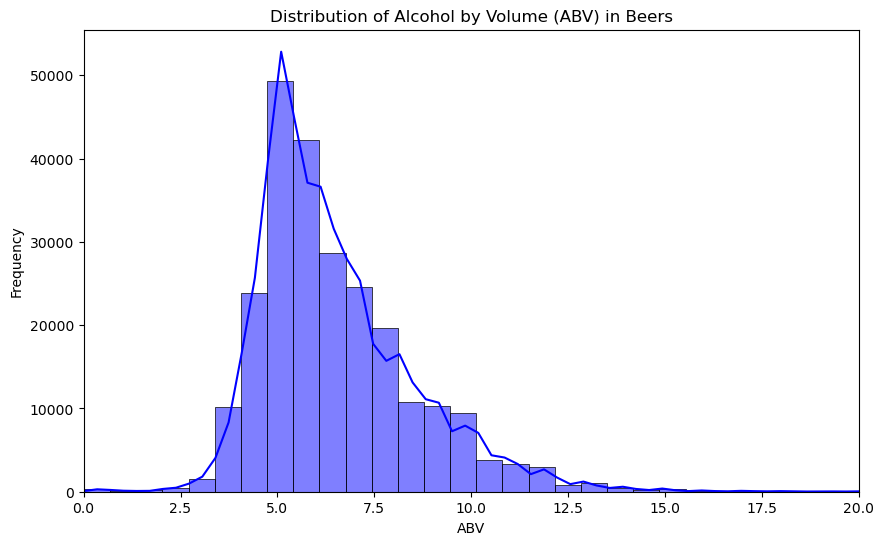

In [104]:
plt.figure(figsize=(10,6))
sns.histplot(ba_beers_df['abv'].dropna(), kde=True, color='blue', bins=100)
plt.title("Distribution of Alcohol by Volume (ABV) in Beers")
plt.xlabel("ABV")
plt.ylabel("Frequency")
plt.xlim(0, 20)
plt.show()

Compute median ABV in rated beers per year

In [105]:
yearly_abv_df = final_merged_df.groupby('year')['abv'].median().reset_index()

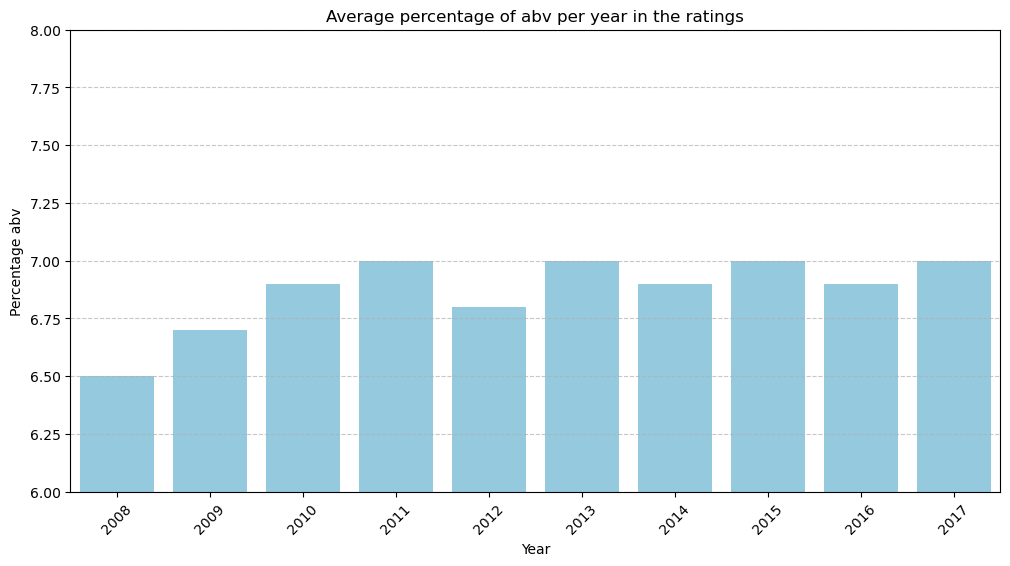

In [106]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=yearly_abv_df, x='year', y='abv', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(6, 8)

# Display the plot
plt.show()

-> Does not look like there is a real trend

Do the same as before but per IPA/NON IPA

In [107]:
yearly_abv_df = final_merged_df.groupby(['year', 'macro_group'])['abv'].median().reset_index()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\3257971005.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=yearly_abv_df, x='year', y='abv', hue='macro_group', color='skyblue')


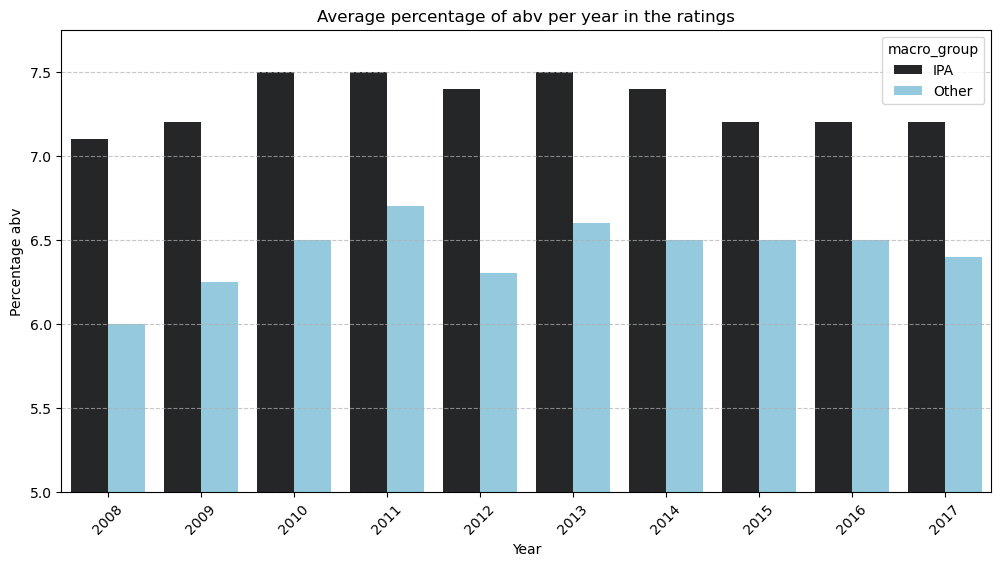

In [108]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=yearly_abv_df, x='year', y='abv', hue='macro_group', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(5, 7.75)

# Display the plot
plt.show()

Do well rated beer have more ABV?

In [109]:
threshold = 4.5
final_merged_df['good_rating'] = final_merged_df['rating'] > threshold
abv_depend_ratings = final_merged_df.groupby(['good_rating', 'year'])['abv'].median().reset_index().copy()
print(abv_depend_ratings)

    good_rating  year   abv
0         False  2008  6.20
1         False  2009  6.50
2         False  2010  6.80
3         False  2011  6.80
4         False  2012  6.60
5         False  2013  6.90
6         False  2014  6.75
7         False  2015  6.80
8         False  2016  6.70
9         False  2017  6.80
10         True  2008  8.20
11         True  2009  8.30
12         True  2010  8.30
13         True  2011  8.30
14         True  2012  8.30
15         True  2013  8.60
16         True  2014  8.30
17         True  2015  8.10
18         True  2016  8.20
19         True  2017  8.20


C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_4688\3160200592.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=abv_depend_ratings, x='year', y='abv', hue='good_rating', color='skyblue')


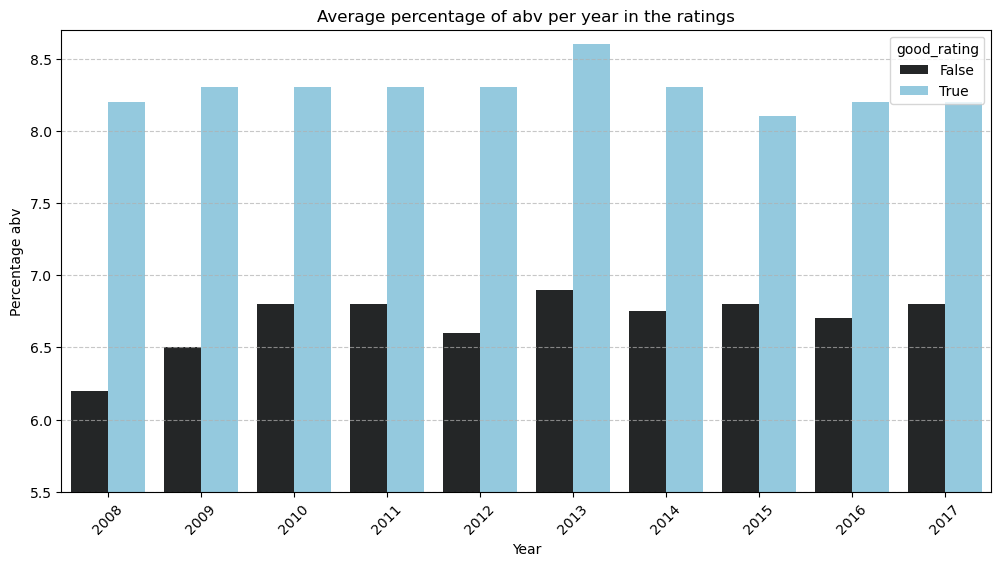

In [110]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=abv_depend_ratings, x='year', y='abv', hue='good_rating', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(5.5, 8.7)

# Display the plot
plt.show()

<h1 style="font-size: 40px;">Step 2: The rise of the IPA: reviews side</h1>

In this section we investigate the characteristic of IPA by looking at the written reviews for the beers

<h1 style="font-size: 30px;">2.1: Preprocessing</h1>

First of all we need to distinguish between the reviews decribing IPAs and reviwes describing other beeers

In [ ]:
# Filter for IPA beers
ipa_styles = [
    'American IPA', 'English India Pale Ale (IPA)',
    'Belgian IPA', 'American Double / Imperial IPA'
]

# Filter for IPA styles
ipa_reviews_df = ba_reviews_df[ba_reviews_df['style'].isin(ipa_styles)].copy()
ipa_reviews_df.reset_index(drop=True, inplace=True)

print("Total number of IPA reviews:", len(ipa_reviews_df))

# For non-IPA reviews
non_ipa_reviews_df = ba_reviews_df[~ba_reviews_df['style'].isin(ipa_styles)].copy()
non_ipa_reviews_df.reset_index(drop=True, inplace=True)

Total number of IPA reviews: 476963


We select 100'000 beers of IPA and of non IPA. We chose to take 100 as the minimum number of reviews a beer must have and 1000 the maximum number of reviews to process per beer

In [ ]:
# Set parameters
review_threshold = 100  # Minimum number of reviews a beer must have
max_reviews_per_beer = 1000  # Maximum number of reviews to process per beer
sample_size = 100000  # Total reviews to process per category

# For IPA reviews
ipa_review_counts = ipa_reviews_df['beer_id'].value_counts()
ipa_beers_selected = ipa_review_counts[ipa_review_counts >= review_threshold].index.tolist()

ipa_reviews_filtered = ipa_reviews_df[ipa_reviews_df['beer_id'].isin(ipa_beers_selected)]
ipa_reviews_filtered = ipa_reviews_filtered.groupby('beer_id').head(max_reviews_per_beer).reset_index(drop=True)

# For Non-IPA reviews
non_ipa_review_counts = non_ipa_reviews_df['beer_id'].value_counts()
non_ipa_beers_selected = non_ipa_review_counts[non_ipa_review_counts >= review_threshold].index.tolist()

non_ipa_reviews_filtered = non_ipa_reviews_df[non_ipa_reviews_df['beer_id'].isin(non_ipa_beers_selected)]
non_ipa_reviews_filtered = non_ipa_reviews_filtered.groupby('beer_id').head(max_reviews_per_beer).reset_index(drop=True)

# Sample to reduce data size
ipa_reviews_filtered = ipa_reviews_filtered.sample(n=sample_size, random_state=42)
non_ipa_reviews_filtered = non_ipa_reviews_filtered.sample(n=sample_size, random_state=42)

print("Total number of selected IPA reviews:", len(ipa_reviews_filtered))
print("Total number of selected Non-IPA reviews:", len(non_ipa_reviews_filtered))

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


We tokenize the text reviews

In [ ]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    # Lowercase
    text = text.lower()
    # Tokenize with preserve_line=True to avoid sent_tokenize
    tokens = word_tokenize(text, preserve_line=True)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

# Apply preprocessing
print("Preprocessing IPA reviews...")
ipa_reviews_filtered['tokens'] = ipa_reviews_filtered['text'].progress_apply(preprocess_text)

print("Preprocessing Non-IPA reviews...")
non_ipa_reviews_filtered['tokens'] = non_ipa_reviews_filtered['text'].progress_apply(preprocess_text)

# Remove entries with empty tokens
ipa_reviews_filtered = ipa_reviews_filtered[ipa_reviews_filtered['tokens'].str.len() > 0].reset_index(drop=True)
non_ipa_reviews_filtered = non_ipa_reviews_filtered[non_ipa_reviews_filtered['tokens'].str.len() > 0].reset_index(drop=True)

print(f"Total IPA reviews after preprocessing: {len(ipa_reviews_filtered)}")
print(f"Total Non-IPA reviews after preprocessing: {len(non_ipa_reviews_filtered)}")

Preprocessing IPA reviews...


100%|██████████| 100000/100000 [00:58<00:00, 1699.65it/s]


Preprocessing Non-IPA reviews...


100%|██████████| 100000/100000 [00:55<00:00, 1816.79it/s]


Total IPA reviews after preprocessing: 99999
Total Non-IPA reviews after preprocessing: 100000


<h1 style="font-size: 30px;">2.2: Comparing Common Words</h1>

In this section, we try to see what are the most common words for each of IPA/Non IPA, in order to see if we are able to obtain meaningful characteristics of the IPA beer

In [ ]:
ipa_tokens_list = ipa_reviews_filtered['tokens'].tolist()
non_ipa_tokens_list = non_ipa_reviews_filtered['tokens'].tolist()
# Combine all tokens for IPA and Non-IPA
ipa_all_tokens = [token for tokens in ipa_tokens_list for token in tokens]
non_ipa_all_tokens = [token for tokens in non_ipa_tokens_list for token in tokens]

# Function to get top N words
def get_top_n_words(tokens, n=20):
    freq_dist = nltk.FreqDist(tokens)
    return freq_dist.most_common(n)

# Get top words for IPA and Non-IPA
ipa_top_words = get_top_n_words(ipa_all_tokens, n=20)
non_ipa_top_words = get_top_n_words(non_ipa_all_tokens, n=20)

print("Top words in IPA reviews:")
print(ipa_top_words)

print("\nTop words in Non-IPA reviews:")
print(non_ipa_top_words)

Top words in IPA reviews:
[('hop', 157609), ('beer', 81268), ('malt', 76239), ('nice', 68435), ('head', 66238), ('pour', 64604), ('citrus', 60852), ('good', 59957), ('taste', 59037), ('ipa', 52763), ('flavor', 52011), ('like', 50562), ('bite', 47519), ('one', 44053), ('sweet', 42717), ('light', 41617), ('orange', 40866), ('pine', 40695), ('bitter', 40570), ('body', 39224)]

Top words in Non-IPA reviews:
[('beer', 96624), ('head', 68288), ('malt', 68215), ('pour', 66826), ('taste', 65202), ('light', 57672), ('nice', 57625), ('flavor', 57598), ('hop', 56972), ('like', 56674), ('dark', 53150), ('good', 52772), ('sweet', 50049), ('bite', 48647), ('one', 42231), ('little', 39556), ('body', 38698), ('bottle', 38529), ('smell', 37967), ('color', 35166)]


Word Cloud for IPA Top Words:


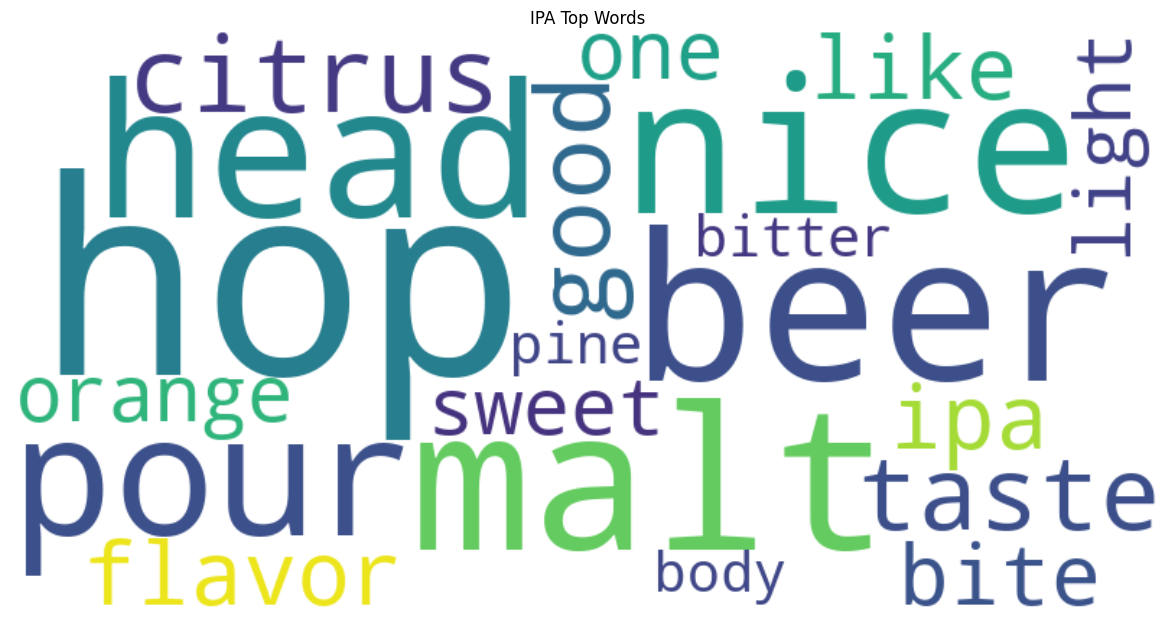

Word Cloud for Non-IPA Top Words:


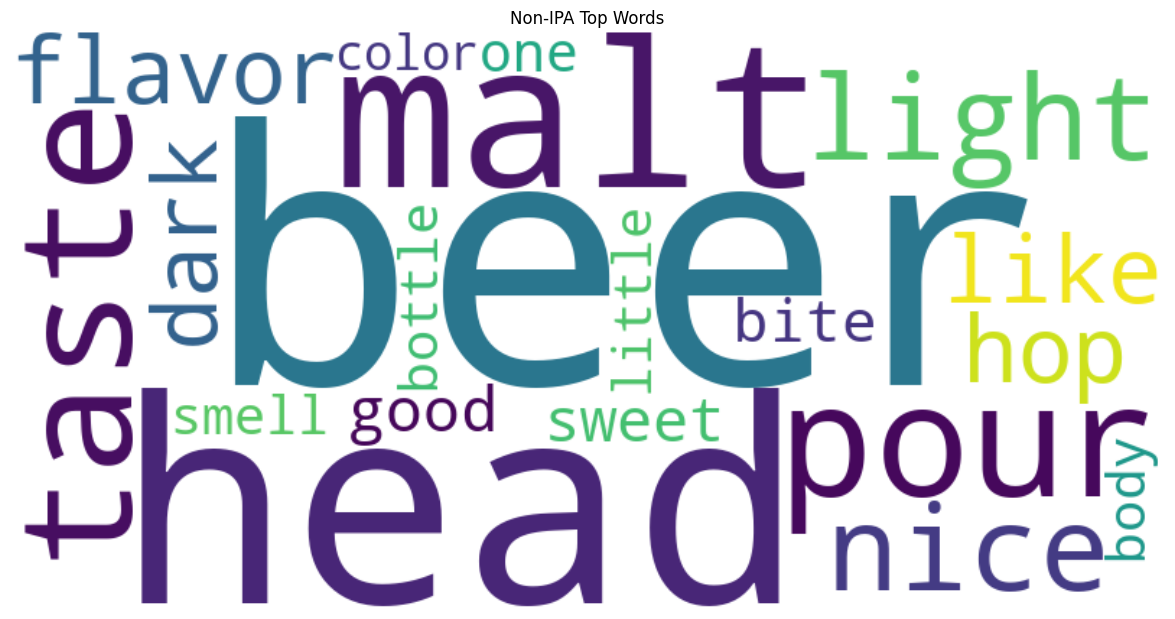

In [ ]:
# Function to create word cloud
def create_wordcloud(word_freq, title=''):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))
    plt.figure(figsize=(15, 7.5))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Create word cloud for IPA top words
print("Word Cloud for IPA Top Words:")
create_wordcloud(ipa_top_words, title='IPA Top Words')

# Create word cloud for Non-IPA top words
print("Word Cloud for Non-IPA Top Words:")
create_wordcloud(non_ipa_top_words, title='Non-IPA Top Words')

This is a good start, but it doesn't give us tastes or beer characteristics

<h1 style="font-size: 30px;">2.3: Comparing Flavors</h1>

Now we try to select only words that contain flavors and see if we can differenciate IPA and other beers

In [ ]:
# Define a list of common beer flavor descriptors
flavor_descriptors = [
    'hoppy', 'bitter', 'citrus', 'pine', 'floral', 'malty', 'sweet', 'roasted', 'caramel',
    'chocolate', 'coffee', 'fruit', 'spicy', 'herbal', 'earthy', 'toffee', 'tropical', 'yeast',
    'banana', 'clove', 'smoke', 'oak', 'vanilla', 'nutty', 'wheat', 'grain', 'sour', 'tart'
]

# Function to count flavor descriptors
def count_flavors(tokens_list, flavor_list):
    flavor_counts = dict.fromkeys(flavor_list, 0)
    for tokens in tokens_list:
        for token in tokens:
            if token in flavor_list:
                flavor_counts[token] += 1
    return flavor_counts

# Count flavors in IPA and Non-IPA reviews
ipa_flavor_counts = count_flavors(ipa_tokens_list, flavor_descriptors)
non_ipa_flavor_counts = count_flavors(non_ipa_tokens_list, flavor_descriptors)

# Convert to DataFrame
ipa_flavor_df = pd.DataFrame(list(ipa_flavor_counts.items()), columns=['Flavor', 'Count_IPA'])
non_ipa_flavor_df = pd.DataFrame(list(non_ipa_flavor_counts.items()), columns=['Flavor', 'Count_Non_IPA'])

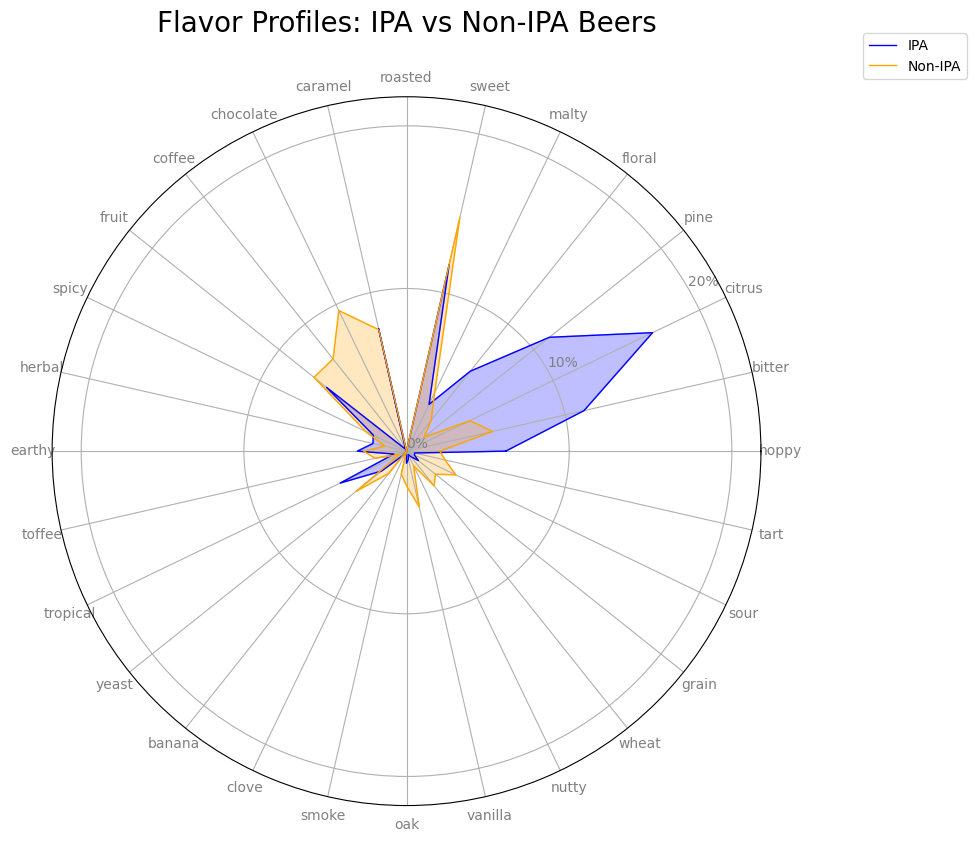

In [ ]:
flavor_comparison_df = ipa_flavor_df.merge(non_ipa_flavor_df, on='Flavor')

flavors = flavor_comparison_df['Flavor']
ipa_counts = flavor_comparison_df['Count_IPA']
non_ipa_counts = flavor_comparison_df['Count_Non_IPA']

total_ipa = ipa_counts.sum()
total_non_ipa = non_ipa_counts.sum()
ipa_percentages = ipa_counts / total_ipa * 100
non_ipa_percentages = non_ipa_counts / total_non_ipa * 100

num_vars = len(flavors)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

angles += angles[:1]
ipa_percentages = ipa_percentages.tolist()
ipa_percentages += ipa_percentages[:1]
non_ipa_percentages = non_ipa_percentages.tolist()
non_ipa_percentages += non_ipa_percentages[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], flavors, color='grey', size=10)
ax.set_rlabel_position(30)
plt.yticks(range(0, int(max(max(ipa_percentages), max(non_ipa_percentages))) + 10, 10),
           [f"{i}%" for i in range(0, int(max(max(ipa_percentages), max(non_ipa_percentages))) + 10, 10)],
           color="grey", size=10)
plt.ylim(0, max(max(ipa_percentages), max(non_ipa_percentages)) + 5)

# Plot IPA data
ax.plot(angles, ipa_percentages, linewidth=1, linestyle='solid', label='IPA', color='blue')
ax.fill(angles, ipa_percentages, alpha=0.25, color='blue')

# Plot Non-IPA data
ax.plot(angles, non_ipa_percentages, linewidth=1, linestyle='solid', label='Non-IPA', color='orange')
ax.fill(angles, non_ipa_percentages, alpha=0.25, color='orange')

# Add title and legend
plt.title('Flavor Profiles: IPA vs Non-IPA Beers', size=20, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

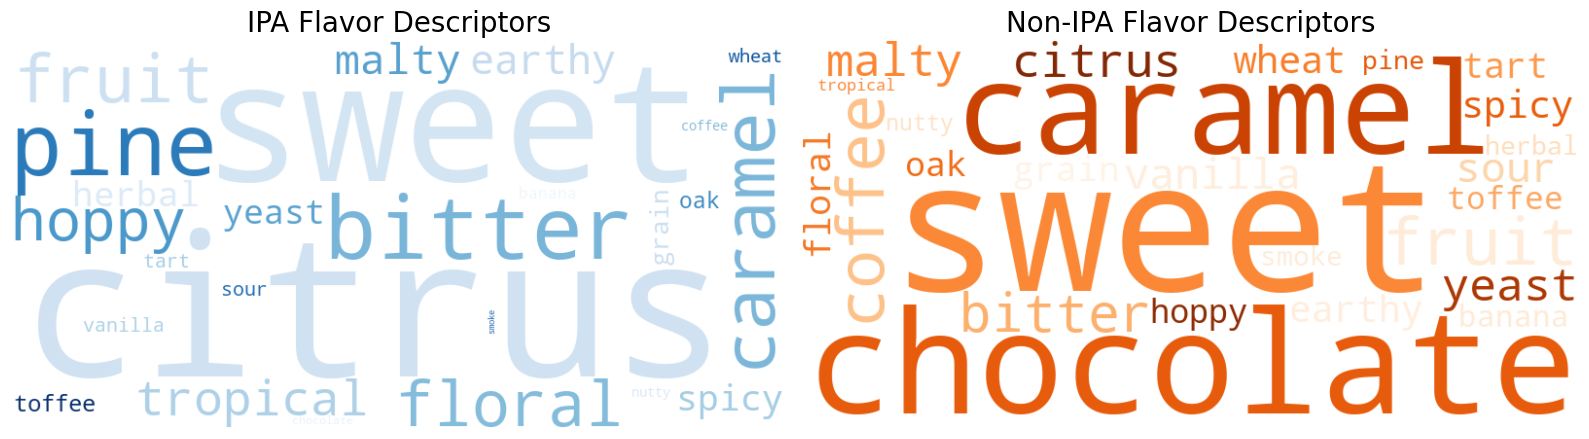

In [ ]:
# Generate word cloud for IPA
ipa_word_freq = dict(zip(flavor_comparison_df['Flavor'], flavor_comparison_df['Count_IPA']))
ipa_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(ipa_word_freq)

# Generate word cloud for Non-IPA
non_ipa_word_freq = dict(zip(flavor_comparison_df['Flavor'], flavor_comparison_df['Count_Non_IPA']))
non_ipa_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(non_ipa_word_freq)

# Plot word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(ipa_wordcloud, interpolation='bilinear')
plt.title('IPA Flavor Descriptors', size=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_ipa_wordcloud, interpolation='bilinear')
plt.title('Non-IPA Flavor Descriptors', size=20)
plt.axis('off')

plt.tight_layout()
plt.show()


It seems that we are able to obtain the most common flavors! Let's visualize more the difference of flavors between IPA and non-IPA beers

C:\Users\danil\AppData\Local\Temp\ipykernel_9316\1417076600.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


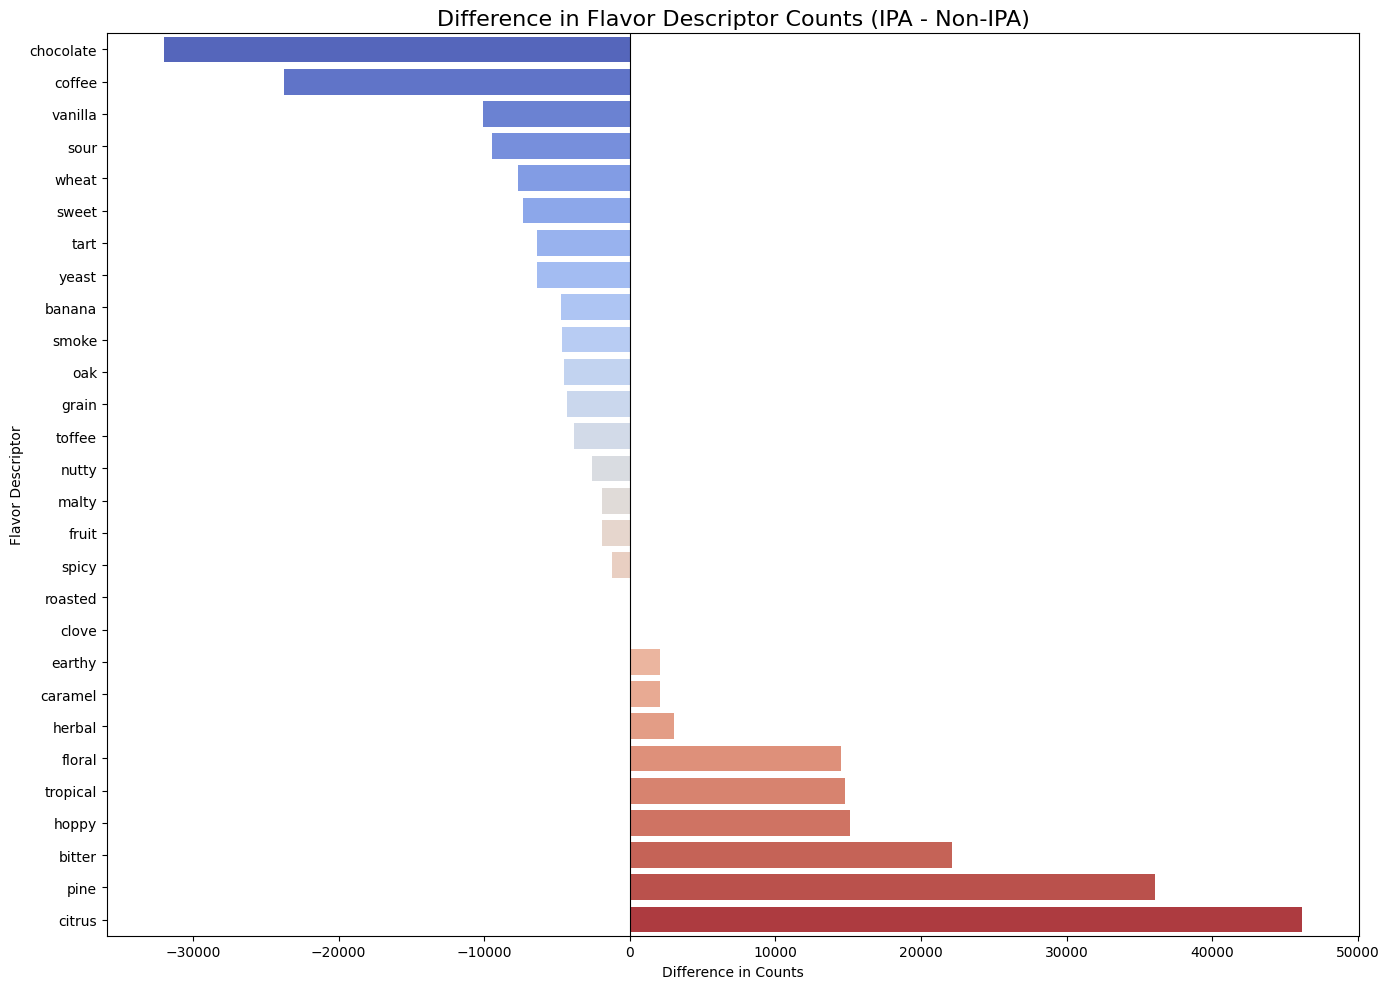

In [ ]:
# Calculate difference in counts
flavor_comparison_df['Difference'] = flavor_comparison_df['Count_IPA'] - flavor_comparison_df['Count_Non_IPA']

# Sort by absolute difference
sorted_flavors = flavor_comparison_df.sort_values('Difference', ascending=True)

# Plot difference bar chart
plt.figure(figsize=(14, 10))
sns.barplot(
    data=sorted_flavors,
    x='Difference',
    y='Flavor',
    palette='coolwarm',
    orient='h'
)
plt.title('Difference in Flavor Descriptor Counts (IPA - Non-IPA)', size=16)
plt.xlabel('Difference in Counts')
plt.ylabel('Flavor Descriptor')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


<h1 style="font-size: 30px;">2.4: Flavors statistical analysis</h1>

That's really interesting! Let's investigate which are statistically significant. First let's see which flavors make the biggest difference between both macro-groups

In [ ]:
# Remove flavors where counts are zero in either IPA or Non-IPA
flavor_comparison_df_filtered = flavor_comparison_df[
    (flavor_comparison_df['Count_IPA'] > 0) & (flavor_comparison_df['Count_Non_IPA'] > 0)
].reset_index(drop=True)

# Prepare data for Chi-square test
chi2_data = flavor_comparison_df_filtered[['Count_IPA', 'Count_Non_IPA']].values

# Perform the Chi-square test
chi2_stat, p_val, dof, ex = chi2_contingency(chi2_data)

print(f"Chi-square Statistic: {chi2_stat:.4f}, p-value: {p_val:.4f}")

# Identify flavors with significant differences
flavor_comparison_df_filtered['IPA_Percentage'] = (
    flavor_comparison_df_filtered['Count_IPA'] / flavor_comparison_df_filtered['Count_IPA'].sum()
) * 100
flavor_comparison_df_filtered['Non_IPA_Percentage'] = (
    flavor_comparison_df_filtered['Count_Non_IPA'] / flavor_comparison_df_filtered['Count_Non_IPA'].sum()
) * 100
flavor_comparison_df_filtered['Difference'] = (
    flavor_comparison_df_filtered['IPA_Percentage'] - flavor_comparison_df_filtered['Non_IPA_Percentage']
)

# Flavors with the biggest differences
flavor_comparison_df_filtered['Abs_Difference'] = flavor_comparison_df_filtered['Difference'].abs()
significant_flavors = flavor_comparison_df_filtered.sort_values(
    'Abs_Difference', ascending=False
).reset_index(drop=True)

print("\nFlavors sorted by difference in usage between IPA and Non-IPA reviews:")
print(significant_flavors[['Flavor', 'IPA_Percentage', 'Non_IPA_Percentage', 'Difference']])

Chi-square Statistic: 186045.2861, p-value: 0.0000

Flavors sorted by difference in usage between IPA and Non-IPA reviews:
       Flavor  IPA_Percentage  Non_IPA_Percentage  Difference
0      citrus       16.789352            4.324241   12.465111
1        pine       11.227941            1.371741    9.856201
2   chocolate        0.150644            9.595406   -9.444762
3      coffee        0.239761            7.246966   -7.007205
4      bitter       11.193453            5.432719    5.760734
5       hoppy        6.101080            2.054811    4.046270
6    tropical        4.531183            0.487317    4.043865
7      floral        6.288144            2.435113    3.853031
8     vanilla        0.513459            3.520006   -3.006547
9       sweet       11.785821           14.754838   -2.969017
10       sour        0.531392            3.363758   -2.832365
11      wheat        0.442551            2.728447   -2.285895
12      yeast        1.960855            3.969293   -2.008438
13       

Now let's actually compute the statistical significance of each flavor

In [ ]:
# Function to perform Chi-square test for individual flavors
def chi_square_individual_flavor(counts_ipa, counts_non_ipa):
    observed = np.array([counts_ipa, counts_non_ipa])
    total = observed.sum()
    expected = np.array([
        (observed.sum(axis=0) * observed.sum(axis=1)[0]) / total,
        (observed.sum(axis=0) * observed.sum(axis=1)[1]) / total
    ])
    chi2_stat = ((observed - expected) ** 2 / expected).sum()
    p_value = chi2.sf(chi2_stat, df=1)
    return chi2_stat, p_value

# Perform Chi-square test for each flavor
significant_flavors['Chi2_Stat'] = 0.0
significant_flavors['P_Value'] = 0.0

for idx, row in significant_flavors.iterrows():
    obs = np.array([
        [row['Count_IPA'], flavor_comparison_df_filtered['Count_IPA'].sum() - row['Count_IPA']],
        [row['Count_Non_IPA'], flavor_comparison_df_filtered['Count_Non_IPA'].sum() - row['Count_Non_IPA']]
    ])
    chi2_stat, p_value, _, _ = chi2_contingency(obs)
    significant_flavors.loc[idx, 'Chi2_Stat'] = chi2_stat
    significant_flavors.loc[idx, 'P_Value'] = p_value

# Adjust p-values for multiple comparisons using Bonferroni correction
significant_flavors['Adjusted_P_Value'] = significant_flavors['P_Value'] * len(significant_flavors)
significant_flavors['Significant'] = significant_flavors['Adjusted_P_Value'] < 0.05

print("\nSignificant flavors after Bonferroni correction:")
print(significant_flavors[['Flavor', 'Chi2_Stat', 'Adjusted_P_Value', 'Significant']])


Significant flavors after Bonferroni correction:
       Flavor     Chi2_Stat  Adjusted_P_Value  Significant
0      citrus  28344.478334      0.000000e+00         True
1        pine  28154.935858      0.000000e+00         True
2   chocolate  34776.925766      0.000000e+00         True
3      coffee  24609.193759      0.000000e+00         True
4      bitter   7549.567028      0.000000e+00         True
5       hoppy   7219.317055      0.000000e+00         True
6    tropical  11414.756685      0.000000e+00         True
7      floral   6149.285496      0.000000e+00         True
8     vanilla   8212.442240      0.000000e+00         True
9       sweet   1345.987774     2.982217e-293         True
10       sour   7537.393500      0.000000e+00         True
11      wheat   6007.450823      0.000000e+00         True
12      yeast   2482.921962      0.000000e+00         True
13       tart   4538.076806      0.000000e+00         True
14     banana   3528.857618      0.000000e+00         True
15    

Let's visualize!

C:\Users\danil\AppData\Local\Temp\ipykernel_9316\154065182.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


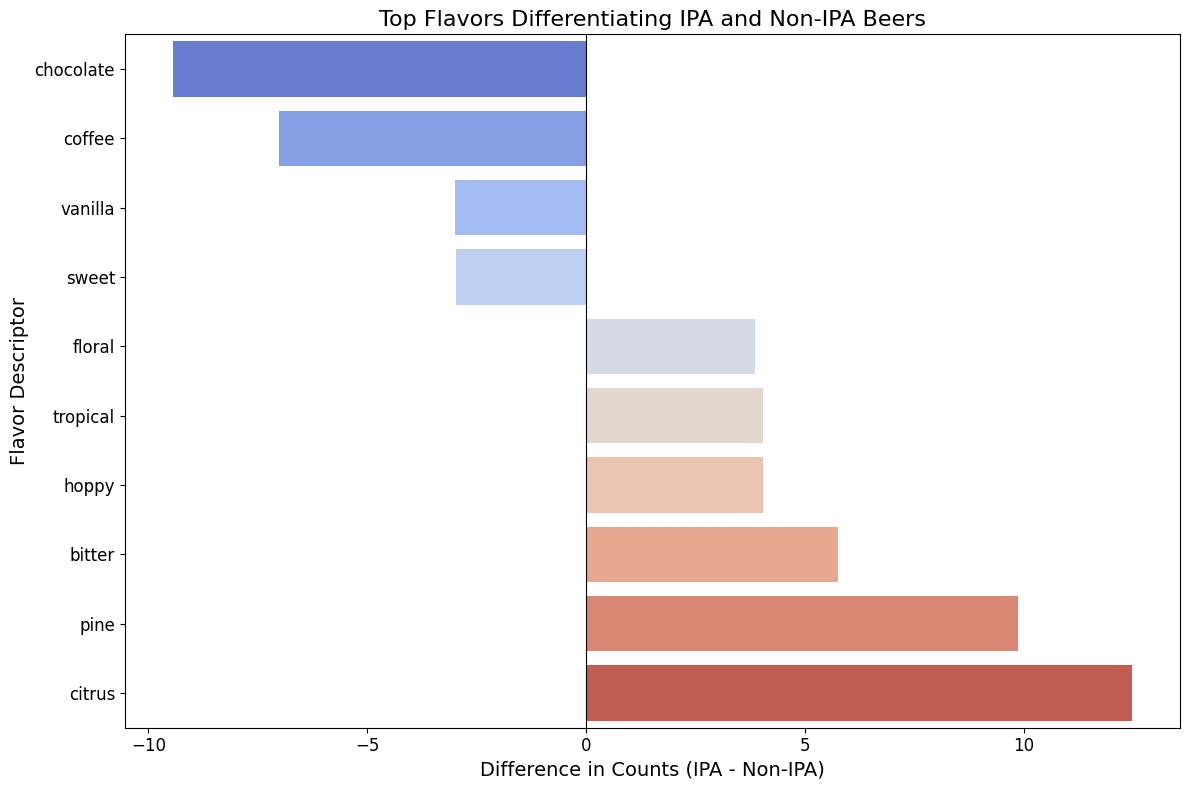

In [ ]:
# Plotting significant flavors
top_flavors_melted = significant_flavors.head(10).melt(
    id_vars='Flavor',
    value_vars=['Count_IPA', 'Count_Non_IPA'],
    var_name='Beer_Type',
    value_name='Count'
)
top_flavors_melted['Beer_Type'] = top_flavors_melted['Beer_Type'].str.replace('Count_', '')

# Select the top 10 flavors with the largest absolute differences
top_flavors = significant_flavors.copy()
top_flavors['Abs_Difference'] = top_flavors['Difference'].abs()
top_flavors = top_flavors.sort_values('Abs_Difference', ascending=False).head(10)

# Sort flavors for better visualization
top_flavors = top_flavors.sort_values('Difference', ascending=True)

# Plot divergent bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_flavors,
    x='Difference',
    y='Flavor',
    palette='coolwarm',
    orient='h'
)
plt.title('Top Flavors Differentiating IPA and Non-IPA Beers', fontsize=16)
plt.xlabel('Difference in Counts (IPA - Non-IPA)', fontsize=14)
plt.ylabel('Flavor Descriptor', fontsize=14)
plt.axvline(0, color='black', linewidth=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# Prepare data
top_flavors_plotly = top_flavors.copy()
top_flavors_plotly['Flavor'] = top_flavors_plotly['Flavor'].astype(str)

# Create interactive divergent bar chart
fig = px.bar(
    top_flavors_plotly,
    x='Difference',
    y='Flavor',
    orientation='h',
    color='Difference',
    color_continuous_scale='Tealrose',
    title='Top Flavors Differentiating IPA and Non-IPA Beers',
    labels={'Difference': 'Difference in Counts (IPA - Non-IPA)', 'Flavor': 'Flavor Descriptor'},
    height=600,
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Difference in Counts (IPA - Non-IPA)',
    yaxis_title='Flavor Descriptor',
    coloraxis_showscale=False,
    plot_bgcolor='white',
    font=dict(size=12),
)
fig.add_vline(x=0, line_width=1, line_color='black')

# Show interactive plot
fig.show()

<h1 style="font-size: 30px;">2.5: Sentiment analysis (and rating variance)</h1>

Now we use Vader, to check the positivity/negativity of the reviews for IPA or for other beers. Plus we also check the difference in terms of ratings, focusing on the distributions rather than on the mean.

In [ ]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiments
def compute_sentiments(texts):
    sentiments = [sia.polarity_scores(text)['compound'] for text in texts]
    return sentiments

# Compute sentiments for IPA reviews
ipa_reviews_filtered['compound_sentiment'] = compute_sentiments(ipa_reviews_filtered['text'])

# Compute sentiments for Non-IPA reviews
non_ipa_reviews_filtered['compound_sentiment'] = compute_sentiments(non_ipa_reviews_filtered['text'])

Calculating Sentiment and Rating Variance and Standard Deviation

In [ ]:
# Calculate sentiment variance and standard deviation for IPA beers
ipa_sentiment_stats = ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].agg(['var', 'std', 'median']).reset_index()
ipa_sentiment_stats.rename(columns={'var': 'sentiment_variance', 'std': 'sentiment_std', 'median': 'sentiment_median'}, inplace=True)
ipa_sentiment_stats['beer_type'] = 'IPA'

# Calculate sentiment variance and standard deviation for Non-IPA beers
non_ipa_sentiment_stats = non_ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].agg(['var', 'std', 'median']).reset_index()
non_ipa_sentiment_stats.rename(columns={'var': 'sentiment_variance', 'std': 'sentiment_std', 'median': 'sentiment_median'}, inplace=True)
non_ipa_sentiment_stats['beer_type'] = 'Non-IPA'

# Combine sentiment stats data
combined_sentiment_stats = pd.concat([ipa_sentiment_stats, non_ipa_sentiment_stats], ignore_index=True)

# Calculate rating variance and standard deviation for IPA beers
ipa_rating_stats = ipa_reviews_filtered.groupby('beer_id')['rating'].agg(['var', 'std', 'median']).reset_index()
ipa_rating_stats.rename(columns={'var': 'rating_variance', 'std': 'rating_std', 'median': 'rating_median'}, inplace=True)
ipa_rating_stats['beer_type'] = 'IPA'

# Calculate rating variance and standard deviation for Non-IPA beers
non_ipa_rating_stats = non_ipa_reviews_filtered.groupby('beer_id')['rating'].agg(['var', 'std', 'median']).reset_index()
non_ipa_rating_stats.rename(columns={'var': 'rating_variance', 'std': 'rating_std', 'median': 'rating_median'}, inplace=True)
non_ipa_rating_stats['beer_type'] = 'Non-IPA'

# Combine rating stats data
combined_rating_stats = pd.concat([ipa_rating_stats, non_ipa_rating_stats], ignore_index=True)

Calculating Entropy of Ratings and Sentiments

In [ ]:
# Function to calculate entropy
def calculate_entropy(values):
    hist, bin_edges = np.histogram(values, bins=10, range=(0, 1), density=True)
    hist = hist[hist > 0]
    return entropy(hist)

# Calculate entropy for sentiment scores
ipa_entropy_sentiment = ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].apply(calculate_entropy).reset_index(name='sentiment_entropy')
ipa_entropy_sentiment['beer_type'] = 'IPA'

non_ipa_entropy_sentiment = non_ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].apply(calculate_entropy).reset_index(name='sentiment_entropy')
non_ipa_entropy_sentiment['beer_type'] = 'Non-IPA'

combined_entropy_sentiment = pd.concat([ipa_entropy_sentiment, non_ipa_entropy_sentiment], ignore_index=True)

# Calculate entropy for ratings
ipa_entropy_rating = ipa_reviews_filtered.groupby('beer_id')['rating'].apply(calculate_entropy).reset_index(name='rating_entropy')
ipa_entropy_rating['beer_type'] = 'IPA'

non_ipa_entropy_rating = non_ipa_reviews_filtered.groupby('beer_id')['rating'].apply(calculate_entropy).reset_index(name='rating_entropy')
non_ipa_entropy_rating['beer_type'] = 'Non-IPA'

combined_entropy_rating = pd.concat([ipa_entropy_rating, non_ipa_entropy_rating], ignore_index=True)

c:\Users\danil\Documents\Github\ada-2024-project-data-crusadas\venv310\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning:

invalid value encountered in divide

c:\Users\danil\Documents\Github\ada-2024-project-data-crusadas\venv310\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning:

invalid value encountered in divide



We now visualize!

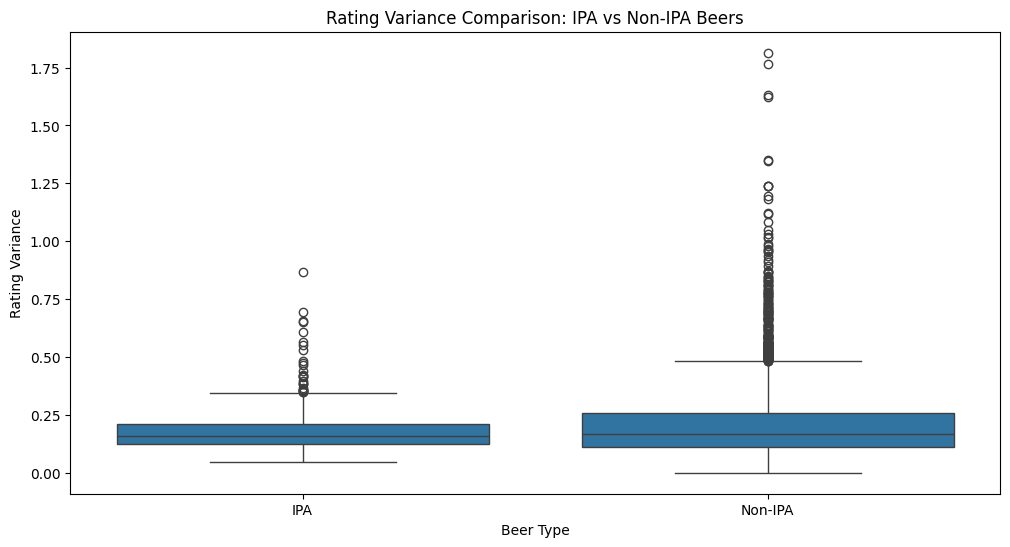

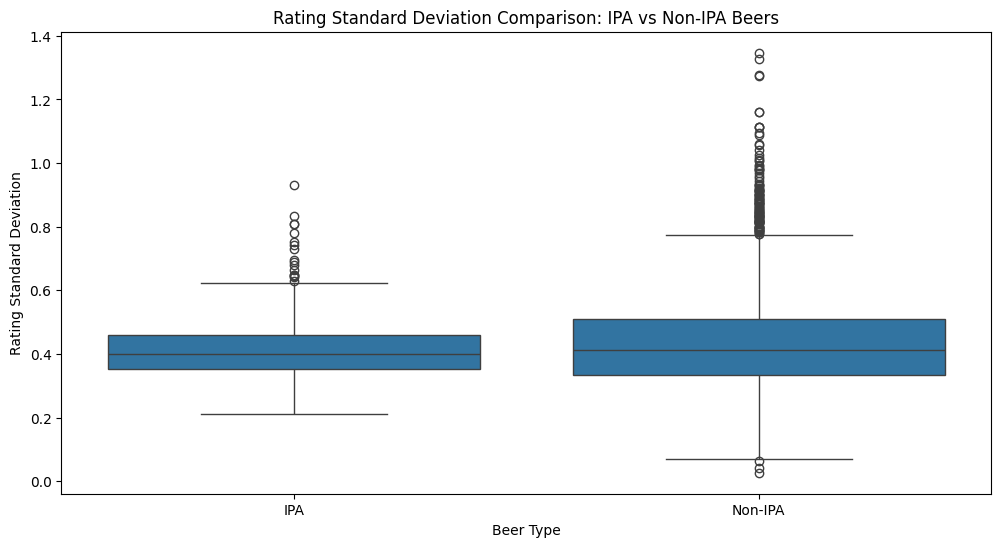

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_rating_stats, x='beer_type', y='rating_variance')
plt.title('Rating Variance Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Rating Variance')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_rating_stats, x='beer_type', y='rating_std')
plt.title('Rating Standard Deviation Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Rating Standard Deviation')
plt.show()

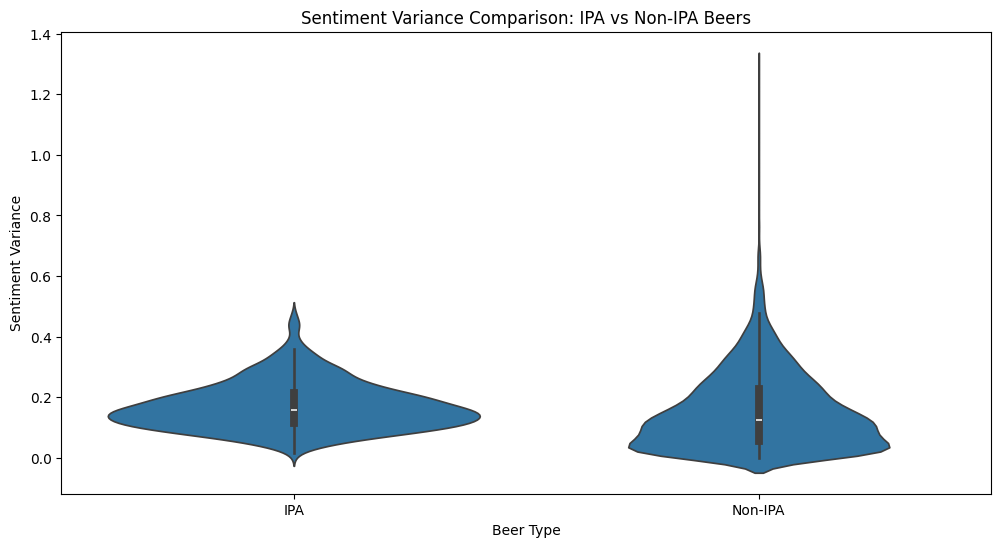

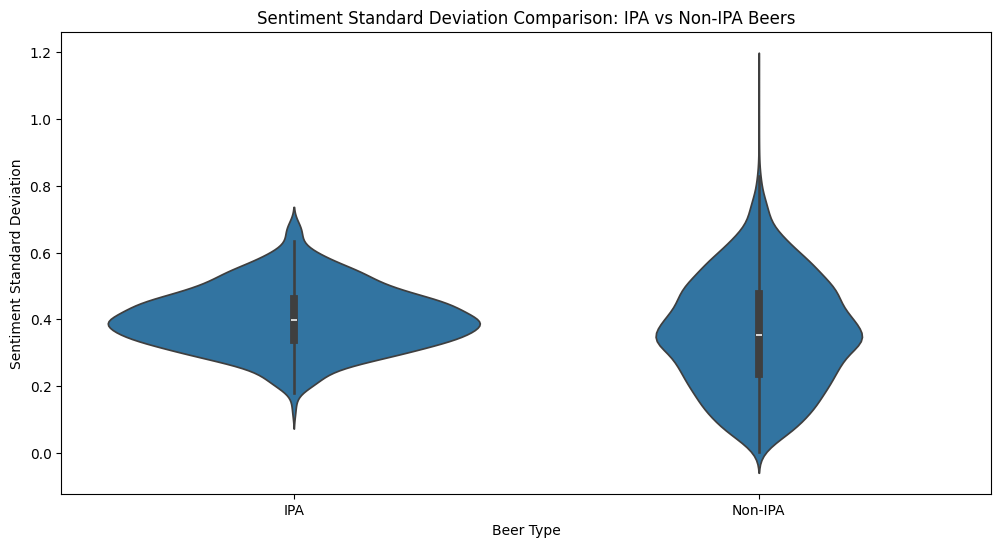

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=combined_sentiment_stats, x='beer_type', y='sentiment_variance')
plt.title('Sentiment Variance Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Sentiment Variance')
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=combined_sentiment_stats, x='beer_type', y='sentiment_std')
plt.title('Sentiment Standard Deviation Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Sentiment Standard Deviation')
plt.show()

CDF Plots for Rating and Sentiment Entropy

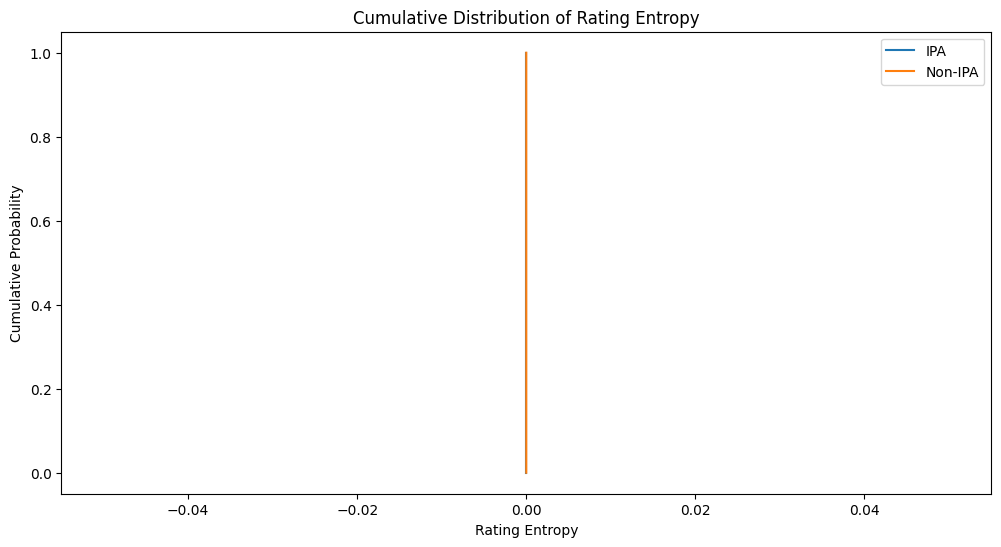

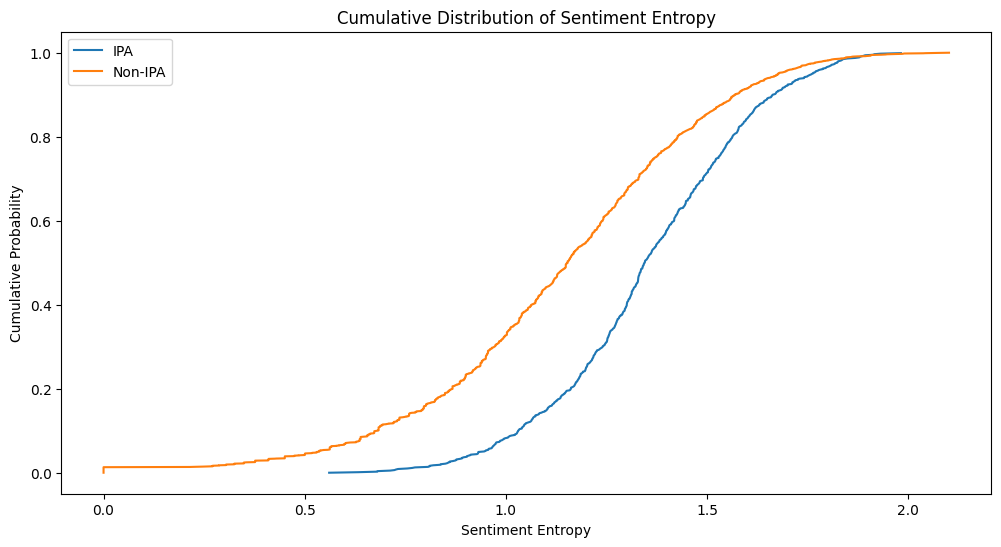

In [ ]:
# Rating Entropy CDF
plt.figure(figsize=(12, 6))
for beer_type, group_data in combined_entropy_rating.groupby('beer_type'):
    sorted_data = np.sort(group_data['rating_entropy'].dropna())
    yvals = np.arange(len(sorted_data))/float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=beer_type)
plt.title('Cumulative Distribution of Rating Entropy')
plt.xlabel('Rating Entropy')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Sentiment Entropy CDF
plt.figure(figsize=(12, 6))
for beer_type, group_data in combined_entropy_sentiment.groupby('beer_type'):
    sorted_data = np.sort(group_data['sentiment_entropy'].dropna())
    yvals = np.arange(len(sorted_data))/float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=beer_type)
plt.title('Cumulative Distribution of Sentiment Entropy')
plt.xlabel('Sentiment Entropy')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

<h1 style="font-size: 40px;">Step 3-4: Beer characteristic and emotions</h1>

We give here an other method to tokenize the words that could be useful for this part because it showed promising results. We do not know if we will use it now but the results it gives beeing interesting, we decide to add it for this stage of the project. 

First we extract tokens from the reviews

In [ ]:
from analysis.process_reviews import get_tokens

# Processes the tokens, using stopwords, removing punctuation, lemmatization and only keeping nouns and adjectives
all_tokens = get_tokens('data/reviews.txt.gz', review_limit=1000000)

We vectorize to create a TF-IDF matrix. We select the top 1000 words only

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TF-IDF Vectorizer with the tokens
vectorizer = TfidfVectorizer(max_features=1000, min_df = 0.005)  # Limit to top 1000 terms, showing terms that appears in at least 0.5% of the docs
X = vectorizer.fit_transform([" ".join(token) for token in all_tokens])  # Transform reviews to TF-IDF matrix

From the top 1000 features of our TF-IDF matrix, we manually select the ones that have something to do with beer

In [ ]:
beer_lexicon = {
    'beer', 'ale', 'lager', 'stout', 'porter', 'pilsner', 'ipa', 'brewer', 
 'brewery', 'brewing', 'draft', 'cask', 'bottle', 'glass', 'pour', 'tap','head', 'foam', 
    'frothy', 'bubbly', 'carbonated', 'flat', 'clarity','hazy', 'opaque', 'cloudy', 'clear', 'golden', 'amber', 'brown', 'dark', 
 'black', 'mahogany', 'ruby', 'white', 'pale', 'yellow', 'beige', 'red', 
 'floral', 'herbal', 'earthy', 'spicy', 'citrusy', 'fruity', 'sweet', 
 'sour', 'bitter', 'bitterness', 'smooth', 'rich', 'dry', 'crisp', 'creamy', 
 'sticky', 'tart', 'tangy', 'sweetness', 'malty', 'hoppy', 'aromatic', 
 'aroma', 'aftertaste', 'subtle', 'intense',
'barley', 'malt', 'malty', 'grain', 'yeast', 'hops', 'hop', 'water', 
 'spices', 'vanilla', 'chocolate', 'caramel', 'toffee', 'coffee', 'cocoa', 
 'citrus', 'orange', 'lemon', 'grapefruit', 'pine', 'oak', 'nutty', 'raisin', 
 'plum', 'cherry', 'maple', 'banana', 'berry', 'ginger','session', 'sessionable', 'pint', 'ounce', 'ounce', 'snifter', 'chalice', 
 'pub', 'bar', 'draught', 'taste', 'drink', 'drinker', 'sip', 'gulp', 
 'quaffable','balanced', 'strong', 'bold', 'weak', 'delicate', 'refreshing', 'complex', 
 'light', 'heavy', 'moderate', 'intense', 'robust', 'unique', 'classic', 
 'distinctive', 'remarkable', 'awesome', 'excellent', 'superb', 'good', 
 'decent', 'ok', 'average', 'bad', 'boring', 'cheap', 'quality','balanced', 'strong', 'bold', 'weak', 'delicate', 'refreshing', 'complex', 
 'light', 'heavy', 'moderate', 'intense', 'robust', 'unique', 'classic', 
 'distinctive', 'remarkable', 'awesome', 'excellent', 'superb', 'good', 
 'decent', 'ok', 'average', 'bad', 'boring', 'cheap', 'aged', 'vintage', 'cellar', 'oak', 'barrel', 'reserve', 'craft', 'microbrewery', 'homebrew', 'regional', 'seasonal', 'festive', 
 'holiday', 'celebration', 'festival', 'special'}

# We filter the beer-related tokens, getting rid of the rest
# Every review is left with beer-related tokens whose vocabulary is the beer_lexicon
all_tokens_beer = [[word for word in sentence if word in beer_lexicon] for sentence in all_tokens]

Create Word Embeddings in order to see which words are close/far from each other

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=all_tokens_beer, vector_size=100, window=3, min_count=1, workers=4)

Let's see if we can find the same characteristic for the IPA that we found before.

In [ ]:
print('Tokens most similar to IPA : \n', model.wv.most_similar('ipa', topn=5))

Tokens most similar to IPA : 
 [('citrusy', 0.7408379316329956), ('refreshing', 0.7262238264083862), ('hoppy', 0.7247021794319153), ('citrus', 0.6414749622344971), ('grapefruit', 0.6351175904273987)]


Seems like we can! Now we can play around with the words to see which seem closer to the other. It will be really useful for the those parts of the project.

In [ ]:
print('Tokens (stout and chocolate) - (citrus and ipa) gives us : \n', 
      model.wv.most_similar(positive=['stout', 'chocolate'], negative=['citrus', 'ipa'], topn=3))

Tokens (stout and chocolate) - (citrus and ipa) gives us : 
 [('coffee', 0.7064121961593628), ('dark', 0.6670213937759399), ('black', 0.6415765881538391)]



With the goal of simplifying our model and reducing the noise, new TF-IDF matrix with vocabulary being beer_lexicon. This will help us find the characteristics of certiain beers later. 

In [ ]:
vectorizer_beer = TfidfVectorizer(vocabulary=beer_lexicon)
X_beer = vectorizer_beer.fit_transform([" ".join(token) for token in all_tokens_beer])